# GO Analysis for WGCNA
## Phase 2 

Gene ontology of modules from [WGCNA](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/wgcna/wgcna_p2.ipynb). Following [Gurr code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/GO_Analysis_WGCNA_all.R)

Since we don't have log fold change (because we aren't looking at differential expression), we can only do an over-representation analysis (ORA) - provide a gene list of interest (genes in a significantly correlated module) and a universal gene list (after filtering for wgcna - so *not* all genes in the CV genome, but rather what went in as input to wgcna)

## 0. load libraries

In [2]:
library(tidyverse)
library(goseq)
library(reshape2)
library(Rmisc)
library(ggpubr)
library(gridExtra)
library(forcats)
library(zoo)
library(ComplexHeatmap)
library(GO.db)
library(GSEABase)
library(clusterProfiler)

## 1. load data
WGCNA module membership, module colors, and goslim_generic.obo

#### A. gene annotation to GO.term - long format
matches GO terms to *C. virginica* genes - one GO term per row (so genes are duplicated among rows)

In [21]:
annot <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'

# One row for each gene and GO.term
term2gene <- annot %>%
  separate_rows(GO.terms, sep = "; ") %>% # one row for each GO.term
  filter(!is.na(GO.terms) & GO.terms != "") %>% # remove genes without GO terms
  dplyr::select(term = GO.terms, gene = Gene) # rename columns for GO 

head(term2gene)

term       gene        
1 GO:0005042 LOC111126949
2 GO:0005737 LOC111126949
3 GO:0008233 LOC111126949
4 GO:0016020 LOC111126949
5 GO:0043123 LOC111126949
6 GO:0046330 LOC111126949

this becomes input for `enricher` down below

get term names for GO IDs

In [20]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

term      
GO:0005042 GO:0005042
GO:0005737 GO:0005737
GO:0008233 GO:0008233
GO:0016020 GO:0016020
GO:0043123 GO:0043123
GO:0046330 GO:0046330
           name                                                          
GO:0005042 netrin receptor activity                                      
GO:0005737 cytoplasm                                                     
GO:0008233 peptidase activity                                            
GO:0016020 membrane                                                      
GO:0043123 positive regulation of canonical NF-kappaB signal transduction
GO:0046330 positive regulation of JNK cascade

#### B. GOslim data

GO Slim - higher level of GO used to summarize GO results into broader categories (the parent terms)

In [4]:
slim <- getOBOCollection("http://current.geneontology.org/ontology/subsets/goslim_generic.obo")
class(slim)

[1] "OBOCollection"
attr(,"package")
[1] "GSEABase"

In [5]:
# 1. Get the GO IDs
slim_ids <- ids(slim)

# 2. Get the IDs that belong to the generic subset
slim_ids <- ids(slim["goslim_generic" ])

# 3. Get the terms for those specific IDs
# use the GO.db package because it's much faster and more reliable for names
slim_terms <- Term(slim_ids)

# 4. Create lookup table 
slim_lookup <- data.frame(
  SlimID = names(slim_terms), # parent ID
  GOSlim_Bin = as.character(slim_terms), # biological term
  stringsAsFactors = FALSE
)

head(slim_lookup)

SlimID     GOSlim_Bin             
1 GO:0000228 nuclear chromosome     
2 GO:0000278 mitotic cell cycle     
3 GO:0000910 cytokinesis            
4 GO:0001618 virus receptor activity
5 GO:0002181 cytoplasmic translation
6 GO:0002376 immune system process

this table can be used to assign GO terms to broader categories - however, this table only contains parent terms (SlimID), so cannot directly be merged with GO results - need to match the parent terms to the GO IDs

In [42]:
# 1. Get a list of all ancestors for every GO term in WGCNA results
# This creates a mapping of Specific_ID -> All_Ancestors
all_ancestors <- as.list(GOBPANCESTOR)

# lookup vector - parent GO terms
target_slim_ids <- unique(slim_lookup$SlimID)

# 2. make lookup function
find_slim_parent <- function(specific_id, slim_ids) {
  if (is.na(specific_id)) return(NA_character_) # if GO term isn't in ancestor lookup
  if (specific_id %in% slim_ids) return(specific_id) # if GO term is the parent term
  
  # Get ancestors from the GO.db object
  ancestors <- all_ancestors[[specific_id]]
  
  if (is.null(ancestors)) return(NA_character_) # if no ancestor term
  
  # Find which ancestors are in your Slim list
  match <- intersect(ancestors, slim_ids)
  
  if (length(match) == 0) return(NA_character_)
  return(as.character(match[1])) 
}


#### C. Gene info
read in gene info from [wgcna_p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/wgcna/wgcna_p2.ipynb)

contains the gene name, matching GO terms, module color, gene significance (GS) for every treatment, and module membership (MM) for each module

In [10]:
geneInfo <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_GeneInfo.csv') 
head(geneInfo) 

Gene        
1 COX1        
2 COX2        
3 COX3        
4 CYTB        
5 LOC111099029
6 LOC111099033
  GO.terms                                                                                                                                                                                      
1 GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872                                                                                                                        
2 GO:0004129; GO:0005507; GO:0005743; GO:0070469                                                                                                                                                
3 GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277                                                                                                                                    
4 GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872                                                                                                                                    
5 GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604                                                                                                            
6 GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837
  ModuleColor Combo_treatments.GS.both_both Combo_treatments.GS.both_warm
1 brown        0.01890862                   -0.0565456949                
2 brown       -0.02712349                   -0.0763355202                
3 brown        0.01199400                   -0.0923327745                
4 brown        0.06678880                   -0.0001181687                
5 blue         0.02251138                    0.0324885000                
6 salmon       0.03262849                   -0.0054834451                
  Combo_treatments.GS.both_control Combo_treatments.GS.both_hypoxic
1 -0.07639120                      -0.15771421                     
2 -0.04636546                      -0.07633242                     
3 -0.02501484                      -0.05114432                     
4 -0.05187666                      -0.32304961                     
5  0.06112436                      -0.04309088                     
6 -0.14770857                       0.24694553                     
  Combo_treatments.GS.control_control Combo_treatments.GS.control_hypoxic
1 -0.07403373                         -0.01311223                        
2  0.01938493                         -0.11795616                        
3  0.02632895                         -0.07263109                        
4  0.08920278                         -0.20809823                        
5  0.03163502                         -0.05860583                        
6 -0.03531460                         -0.10445214                        
  Combo_treatments.GS.control_both ⋯ MMcyan      MMbrown     MMyellow  
1  0.088481991                     ⋯  0.17223558  0.52972753  0.2700327
2  0.177115626                     ⋯  0.20624426  0.60966090  0.1083271
3  0.105828221                     ⋯  0.43047835  0.63169637  0.2772417
4  0.006858974                     ⋯  0.09911882  0.54351840  0.2707225
5 -0.036712566                     ⋯ -0.10486420 -0.17749325 -0.1687577
6  0.128748715                     ⋯ -0.20497309 -0.02989429 -0.4049090
  MMturquoise MMpink      MMblack     MMtan       MMsalmon    MMgreenyellow
1  0.27599905 -0.02328820 -0.04901975  0.03370438 -0.03980008  0.13300933  
2  0.24229607 -0.05538884 -0.03260110 -0.06000427  0.04928647 -0.06837658  
3  0.20909597 -0.08887830 -0.04963871 -0.01473983 -0.18648499 -0.23508693  
4  0.27827386 -0.01382435  0.04921847  0.10926803 -0.08622249  0.05725341  
5 -0.10730071 -0.17455884 -0.12058475  0.03029584  0.08641709 -0.00399179  
6 -0.01626329  0.14476401  0.43674437  0.07854242  0.60551361  0.08920579 

categorize gene info columns

In [11]:
# Get all column names once
all_cols <- names(geneInfo)

# 1. The 16 'Combo_treatments.GS' columns
combo_cols <- grep("^Combo_treatments\\.GS\\.", all_cols, value = TRUE)

# 2. Phase 1 & 2 Driver columns (Temp and DO)
p1_driver_cols <- grep("^phase1_(temp|DO)\\.GS\\.", all_cols, value = TRUE)
p2_driver_cols <- grep("^phase2_(temp|DO)\\.GS\\.", all_cols, value = TRUE)

# 3. Overall Phase Treatment columns
p1_overall_cols <- grep("^phase1_treatment\\.GS\\.", all_cols, value = TRUE)
p2_overall_cols <- grep("^phase2_treatment\\.GS\\.", all_cols, value = TRUE)

# 4. Module Membership (MM) colors
mm_cols <- grep("^MM", all_cols, value = TRUE)

#### Module membership
pull out just the genes, associated GO terms, and which module they're been assigned to

In [12]:
moduleMembership <-  geneInfo %>% dplyr::select(Gene, GO.terms, ModuleColor) # select for genes, GO.ids, modules
head(moduleMembership)

Gene        
1 COX1        
2 COX2        
3 COX3        
4 CYTB        
5 LOC111099029
6 LOC111099033
  GO.terms                                                                                                                                                                                      
1 GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872                                                                                                                        
2 GO:0004129; GO:0005507; GO:0005743; GO:0070469                                                                                                                                                
3 GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277                                                                                                                                    
4 GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872                                                                                                                                    
5 GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604                                                                                                            
6 GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837
  ModuleColor
1 brown      
2 brown      
3 brown      
4 brown      
5 blue       
6 salmon

#### D. universal list
this is the input gene list for wgcna before module assignment, but after gene filtering

In [23]:
universal_genes <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_UniversalGeneList.csv')
head(universal_genes)

gene        
1 LOC111126949
2 LOC111120752
3 LOC111105691
4 LOC111113860
5 LOC111109550
6 LOC111109753

## 2. run GO enrichment
over-representation analysis

#### input data:
- universal_genes
- term2gene (matches gene LOC to GO term)
- term2name (matches GO term to GO description)
- geneInfo (output from WGCNA)

slim_lookup for matching parent GO terms to GO results

### midnightblue module
significantly correlated with phase 1 temperature

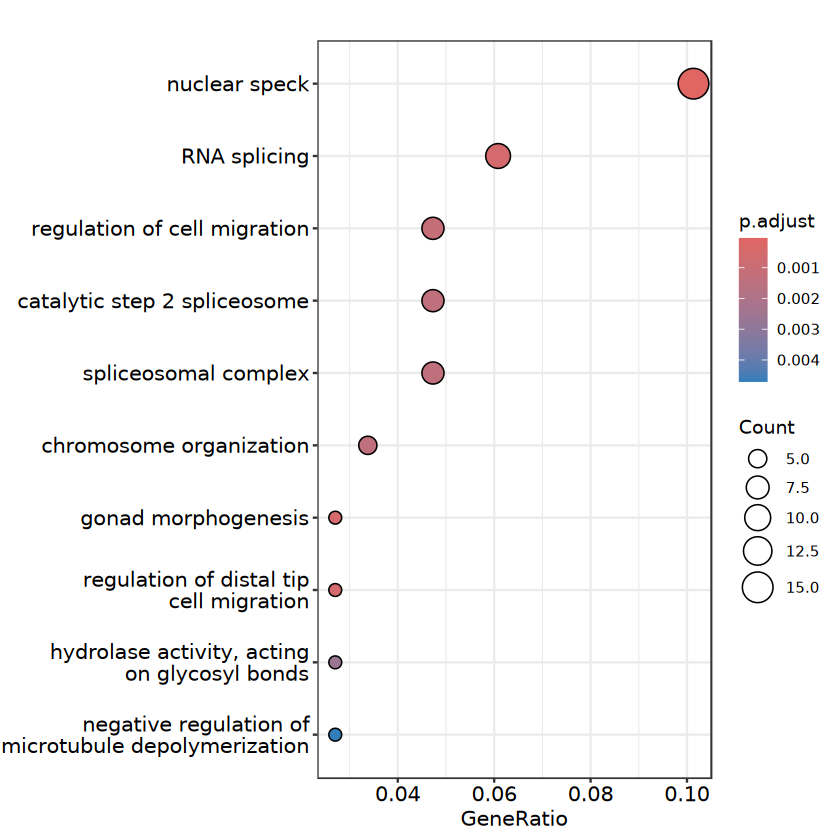

In [45]:
# midnight blue = phase1_temp
target_genes <- geneInfo %>%
  filter(ModuleColor == "midnightblue") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
midnightblue_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [110]:
midnightblue_mapped <- midnightblue_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
midnightblue_final <- midnightblue_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'midnightblue'")

head(midnightblue_final)

ID         Description                                         GeneRatio
1 GO:0035262 gonad morphogenesis                                 4/148    
2 GO:1903354 regulation of distal tip cell migration             4/148    
3 GO:0030334 regulation of cell migration                        7/148    
4 GO:0007026 negative regulation of microtubule depolymerization 4/148    
5 GO:0000398 mRNA splicing, via spliceosome                      8/148    
6 GO:0007004 telomere maintenance via telomerase                 3/148    
  BgRatio   pvalue       p.adjust     qvalue      
1 10/13421  2.832179e-06 0.0005558152 0.0004583659
2 10/13421  2.832179e-06 0.0005558152 0.0004583659
3 65/13421  7.015019e-06 0.0011013579 0.0009082603
4 20/13421  5.996044e-05 0.0047068943 0.0038816494
5 134/13421 1.168935e-04 0.0083419433 0.0068793766
6 13/13421  3.465583e-04 0.0170030174 0.0140219319
  geneID                                                                                                 
1 LOC111123643/LOC111124270/LOC111125152/LOC111125159                                                    
2 LOC111123643/LOC111124270/LOC111125152/LOC111125159                                                    
3 LOC111111223/LOC111115638/LOC111123643/LOC111124270/LOC111125152/LOC111125159/LOC111132609             
4 LOC111111223/LOC111112299/LOC111115638/LOC111135618                                                    
5 LOC111102673/LOC111123630/LOC111124615/LOC111125036/LOC111127735/LOC111132362/LOC111134422/LOC111138362
6 LOC111108767/LOC111127260/LOC111127309                                                                 
  Count SlimID     GOSlim_Bin                module        
1 4     GO:0022414 reproductive process      'midnightblue'
2 4     GO:0048870 cell motility             'midnightblue'
3 7     GO:0048870 cell motility             'midnightblue'
4 4     GO:0007010 cytoskeleton organization 'midnightblue'
5 8     GO:0016071 mRNA metabolic process    'midnightblue'
6 3     GO:0032200 telomere organization     'midnightblue'

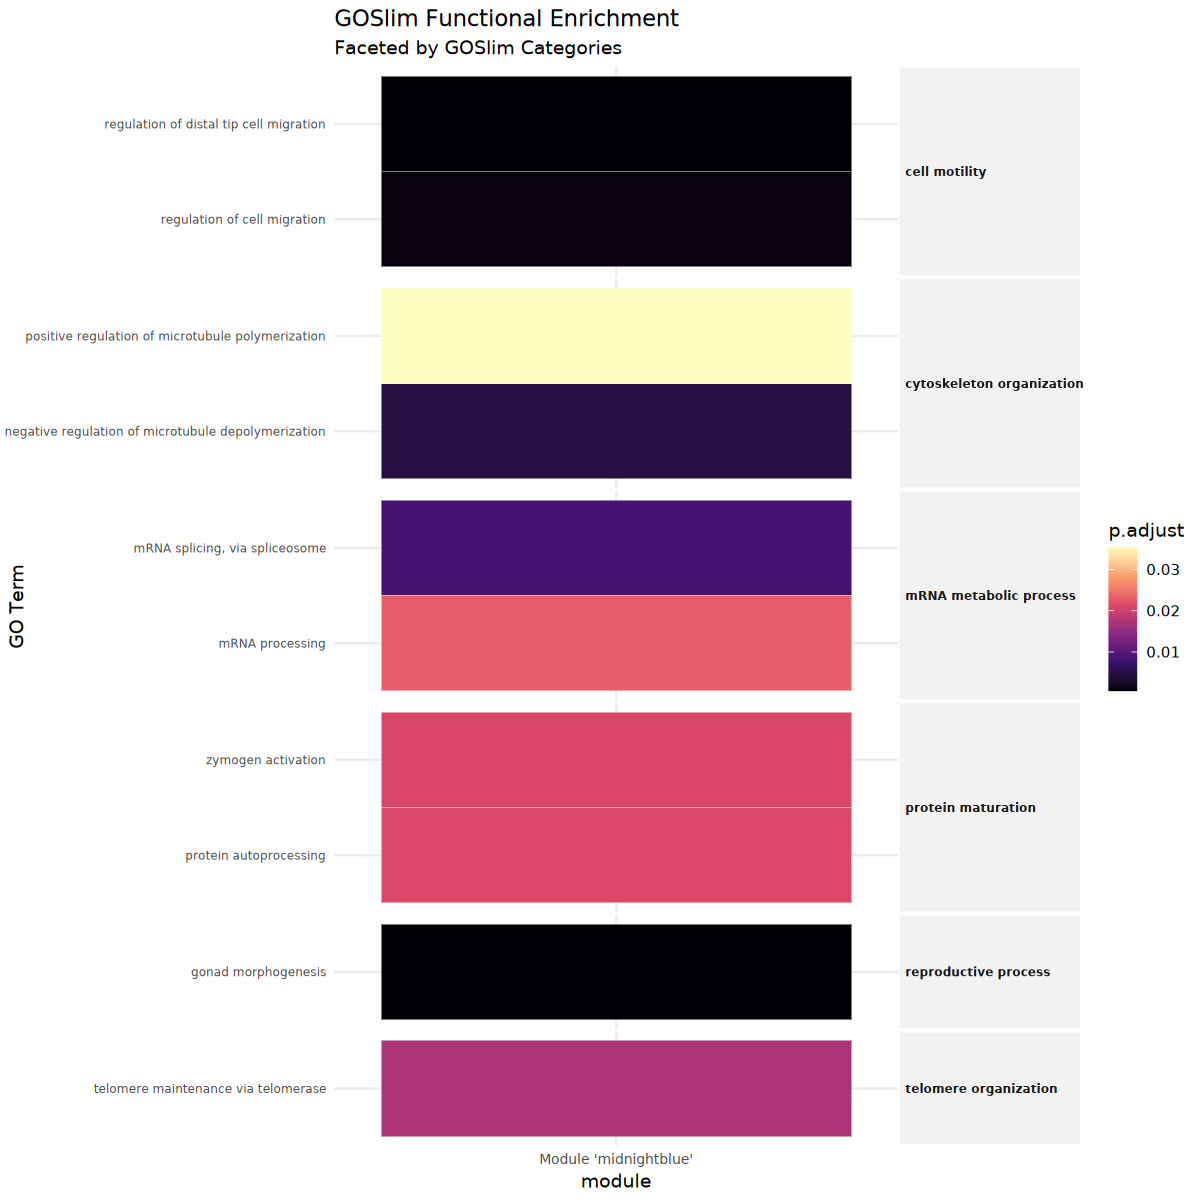

In [58]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(midnightblue_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

### green module
significantly correlated with phase 1 temperature (neg. for warm) and phase 1 treatment (neg. for warm), meaning that the expression of this module is typically lower for warm temps in phase 1, regardless of phase 2 treatment

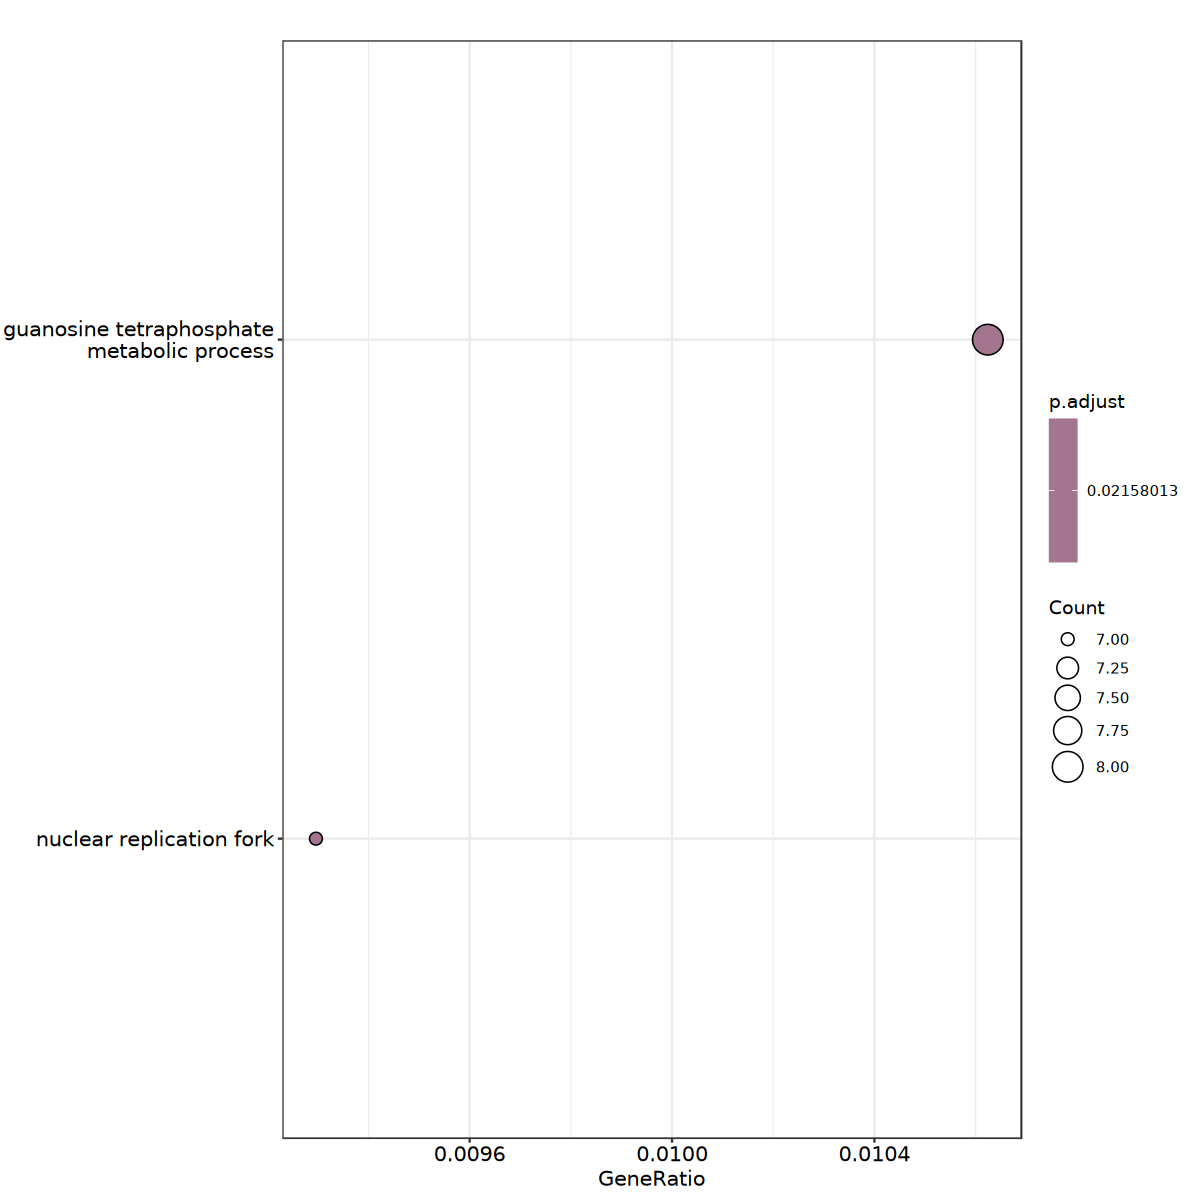

In [100]:
# midnight blue = phase1_temp
target_genes <- geneInfo %>%
  filter(ModuleColor == "green") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
green_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [109]:
green_mapped <- green_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
green_final <- green_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'green'")

head(green_final)

ID         Description                                GeneRatio BgRatio 
1 GO:0015969 guanosine tetraphosphate metabolic process 8/753     23/13421
  pvalue       p.adjust   qvalue    
1 2.182015e-05 0.02158013 0.02142968
  geneID                                                                                                 
1 LOC111106580/LOC111107388/LOC111107389/LOC111107391/LOC111108435/LOC111108877/LOC111109405/LOC111115061
  Count SlimID     GOSlim_Bin                                            
1 8     GO:0055086 nucleobase-containing small molecule metabolic process
  module 
1 'green'

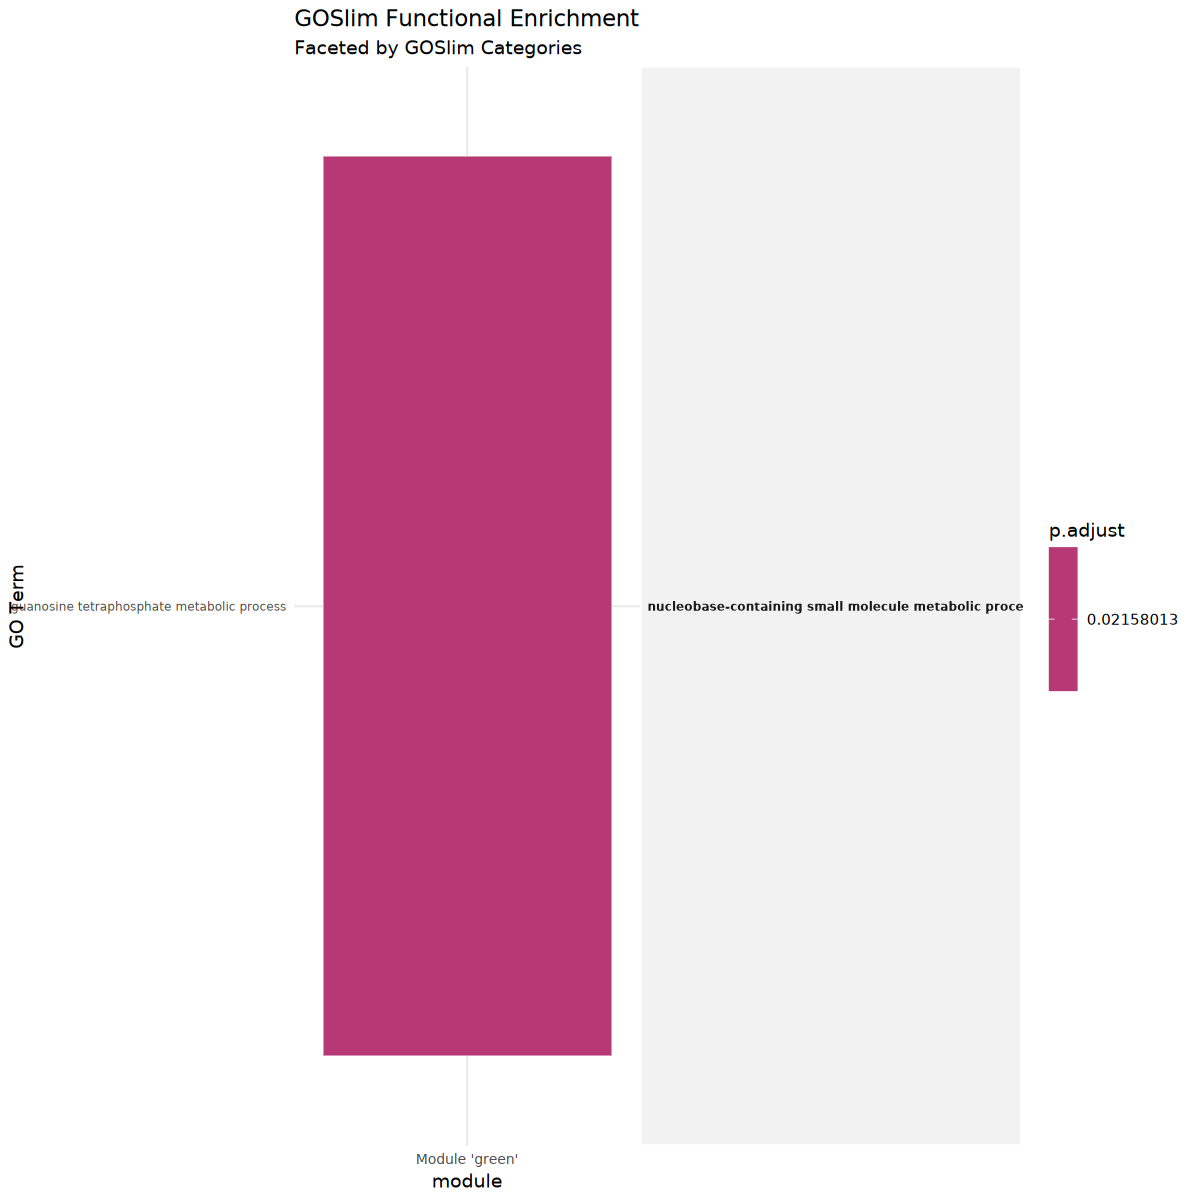

In [102]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(green_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

only two GO terms, but only one that mapped to a parent term (?) - metabolism

### cyan module
significantly correlated with phase 2 temp (pos. with ambient) and phase 2 treatments control (pos.), both and warm (neg.)

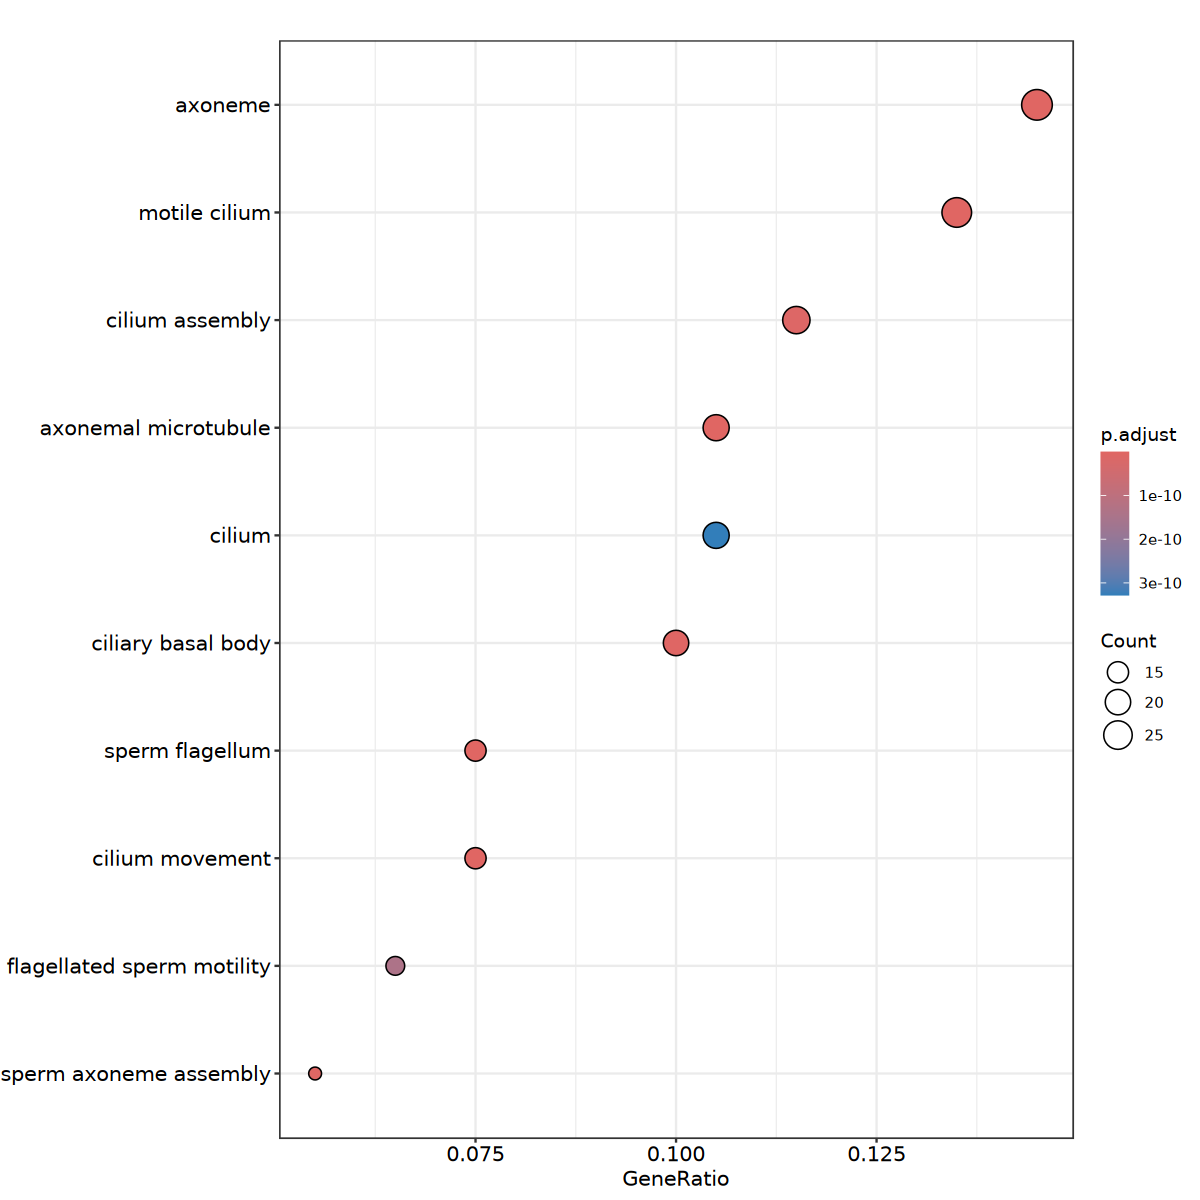

In [64]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "cyan") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
cyan_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [108]:
cyan_mapped <- cyan_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
cyan_final <- cyan_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'cyan'")

head(cyan_final)

ID         Description                               GeneRatio BgRatio  
1 GO:0003341 cilium movement                           15/200    53/13421 
2 GO:0007288 sperm axoneme assembly                    11/200    27/13421 
3 GO:0060271 cilium assembly                           23/200    219/13421
4 GO:0030317 flagellated sperm motility                13/200    59/13421 
5 GO:0005929 cilium                                    21/200    213/13421
6 GO:0060294 cilium movement involved in cell motility 9/200     21/13421 
  pvalue       p.adjust     qvalue      
1 8.897860e-16 8.435172e-14 7.249415e-14
2 6.467911e-14 4.379699e-12 3.764032e-12
3 1.697559e-13 1.005804e-11 8.644151e-12
4 2.681954e-12 1.412496e-10 1.213937e-10
5 6.967245e-12 3.284679e-10 2.822942e-10
6 7.622673e-12 3.284679e-10 2.822942e-10
  geneID                                                                                                                                                                                                                                                                                                    
1 LOC111103394/LOC111104160/LOC111108589/LOC111112623/LOC111118145/LOC111122642/LOC111123910/LOC111124887/LOC111127536/LOC111129512/LOC111129855/LOC111129936/LOC111134321/LOC111137096/LOC111137169                                                                                                        
2 LOC111101808/LOC111103594/LOC111112113/LOC111115421/LOC111120598/LOC111124004/LOC111124606/LOC111125001/LOC111129371/LOC111137096/LOC111137307                                                                                                                                                            
3 LOC111099093/LOC111103394/LOC111103594/LOC111104160/LOC111104435/LOC111107716/LOC111115421/LOC111115715/LOC111118129/LOC111118145/LOC111120729/LOC111122003/LOC111123910/LOC111125668/LOC111129466/LOC111129512/LOC111129936/LOC111130289/LOC111131840/LOC111134336/LOC111134864/LOC111135089/LOC111138059
4 LOC111103394/LOC111104160/LOC111110920/LOC111112113/LOC111120729/LOC111120808/LOC111122642/LOC111124004/LOC111129371/LOC111131580/LOC111134864/LOC111137169/LOC111138334                                                                                                                                  
5 LOC111103594/LOC111103618/LOC111103803/LOC111111551/LOC111112129/LOC111112623/LOC111115715/LOC111118045/LOC111118145/LOC111122642/LOC111122798/LOC111125428/LOC111126154/LOC111129376/LOC111129377/LOC111129466/LOC111129936/LOC111131840/LOC111135560/LOC111138059/LOC111138334                          
6 LOC111101813/LOC111107716/LOC111120563/LOC111120729/LOC111121573/LOC111129936/LOC111134864/LOC111135089/LOC111138334                                                                                                                                                                                      
  Count SlimID     GOSlim_Bin                 module
1 15    GO:0007018 microtubule-based movement 'cyan'
2 11    GO:0007010 cytoskeleton organization  'cyan'
3 23    GO:0044782 cilium organization        'cyan'
4 13    GO:0007018 microtubule-based movement 'cyan'
5 21    GO:0005929 cilium                     'cyan'
6  9    GO:0007018 microtubule-based movement 'cyan'

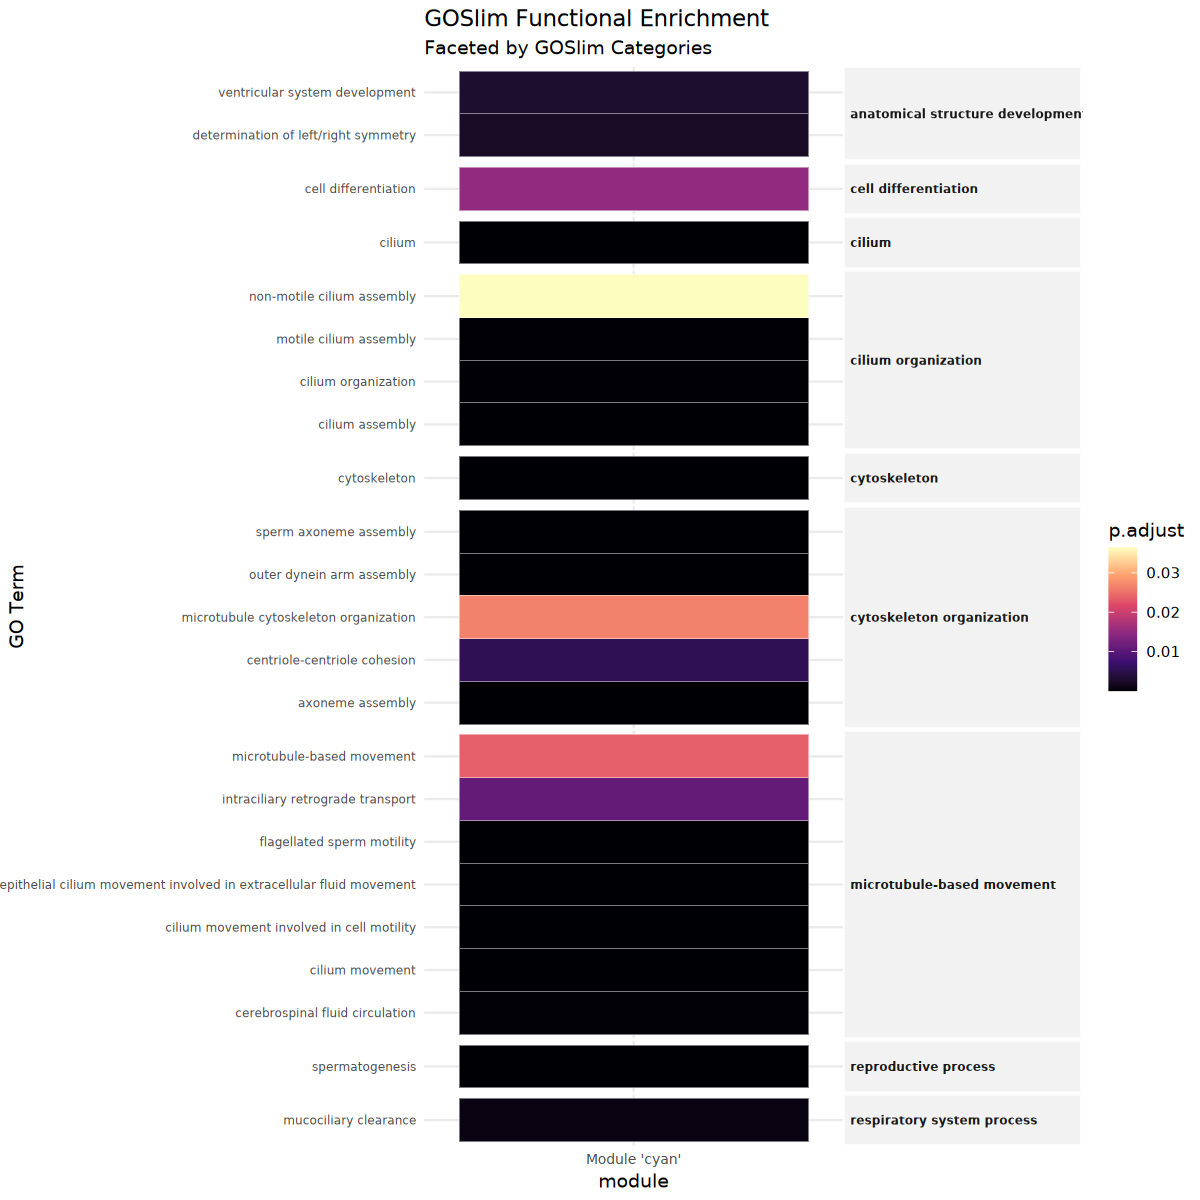

In [66]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(cyan_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

this cyan module is mainly involved in cytoskeleton, cilium - structural development

### yellow module
significantly correlated with phase 2 DO (pos. with normoxic), phase 2 temp (pos. with ambient) and phase 2 treatments control (pos.) and warm (neg.)

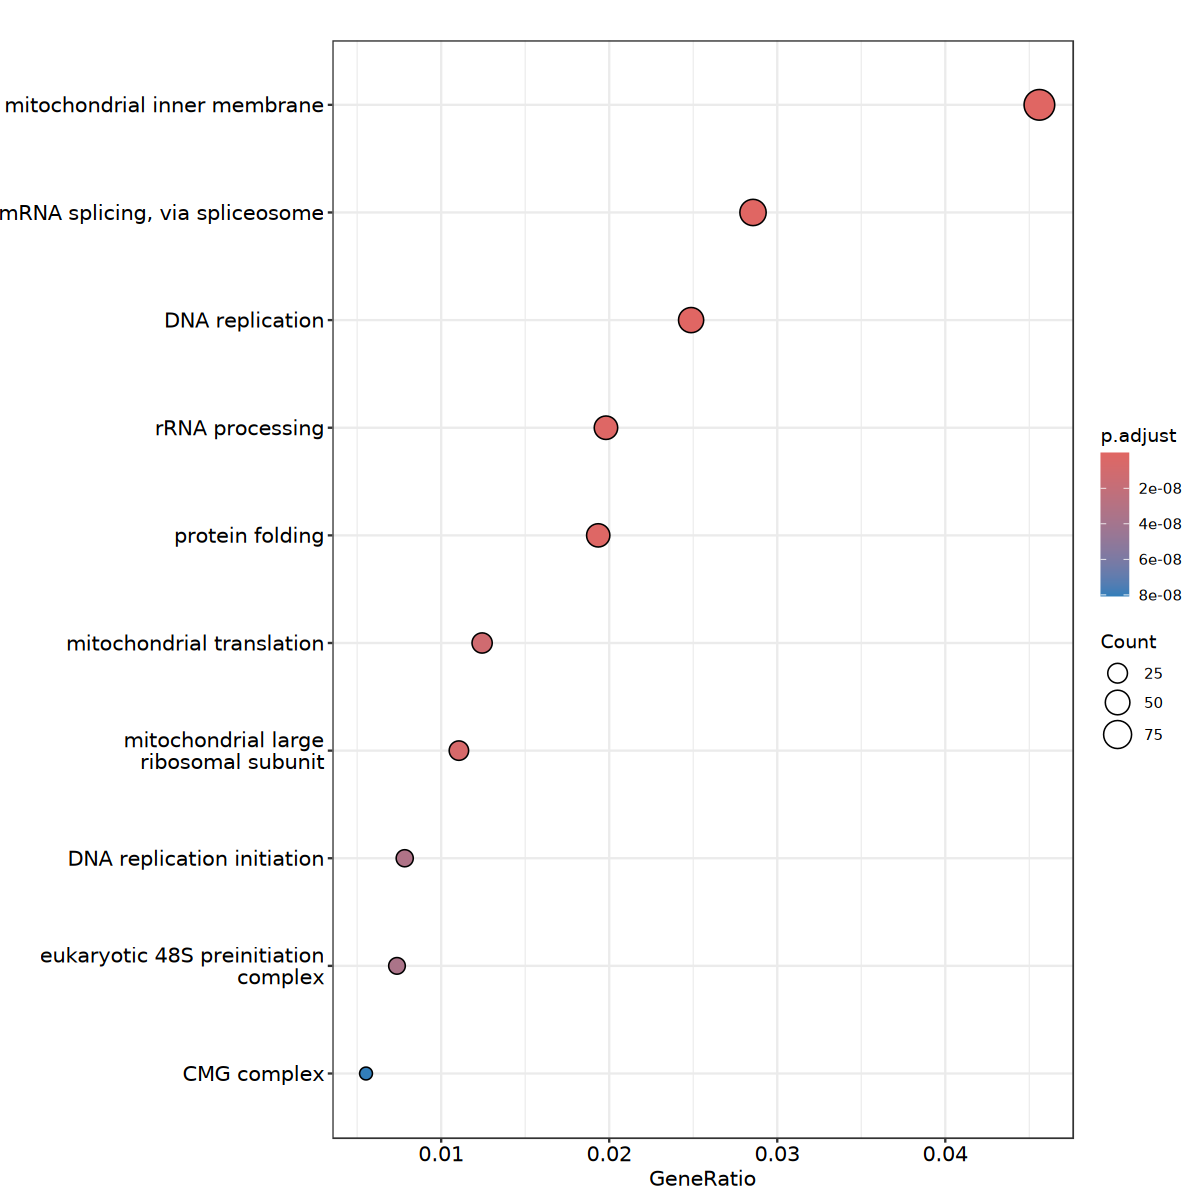

In [67]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "yellow") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
yellow_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [107]:
yellow_mapped <- yellow_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
yellow_final <- yellow_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'yellow'")

head(yellow_final)

ID         Description                    GeneRatio BgRatio   pvalue      
1 GO:0000398 mRNA splicing, via spliceosome 62/2171   134/13421 2.292786e-16
2 GO:0006260 DNA replication                54/2171   112/13421 2.189622e-15
3 GO:0006364 rRNA processing                43/2171   90/13421  2.299277e-12
4 GO:0006457 protein folding                42/2171   87/13421  2.675713e-12
5 GO:0032543 mitochondrial translation      27/2171   45/13421  3.210064e-11
6 GO:0006270 DNA replication initiation     17/2171   21/13421  1.045557e-10
  p.adjust     qvalue      
1 2.958840e-13 2.762203e-13
2 1.883804e-12 1.758612e-12
3 1.381203e-09 1.289412e-09
4 1.381203e-09 1.289412e-09
5 1.183597e-08 1.104938e-08
6 3.373228e-08 3.149052e-08
  geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1 LOC111101512/LOC111102762/LOC111102822/LOC111103914/LOC111104149/LOC111105896/LOC111106208/LOC111106300/LOC111106645/LOC111107715/LOC111108450/LOC111108517/LOC111108640/LOC111108729/LOC111111061/LOC111115058/LOC111118194/LOC111118539/LOC111118582/LOC111119055/LOC111119756/LOC111120267/LOC111120515/LOC111120541/LOC111120794/LOC111120828/LOC111120984/LOC111121008/LOC111121337/LOC111121481/LOC111122102/LOC111122502/LOC111122650/LOC111125507/LOC111126498/LOC111126553/LOC111126802/LOC111128756/LOC111129820/LOC111130068/LOC111130237/LOC111131012/LOC111131375/LOC111131404/LOC111132304/LOC111132305/LOC111132626/LOC111133226/LOC111134475/LOC111134667/LOC111134756/LOC111134942/LOC111135060/LOC111135285/LOC111135387/LOC111135499/LOC111136408/LOC111136413/LOC111136440/LOC111136607/LOC111138363/LOC111138391
2 LOC111100201/LOC111102289/LOC111102580/LOC111102843/LOC111103940/LOC111103948/LOC111104183/LOC111104642/LOC111106945/LOC111107764/LOC111108505/LOC111108617/LOC111109808/LOC111112959/LOC111118262/LOC111118358/LOC111120673/LOC111120775/LOC111120810/LOC111120878/LOC111120888/LOC111120910/LOC111121113/LOC111121171/LOC111121347/LOC111121435/LOC111122245/LOC111122251/LOC111122440/LOC111122897/LOC111123010/LOC111123065/LOC111124294/LOC111125562/LOC111126776/LOC111127828/LOC111128572/LOC111130057/LOC111130346/LOC111130510/LOC111130531/LOC111130645/LOC111131048/LOC111131721/LOC111132235/LOC111132874/LOC111133827/LOC111133987/LOC111134654/LOC111136551/LOC111137179/LOC111137485/LOC111137577/LOC111138461                                                                                                        
3 LOC111099808/LOC111103448/LOC111103981/LOC111104266/LOC111106001/LOC111107584/LOC111108641/LOC111108699/LOC111108747/LOC111110750/LOC111116137/LOC111118140/LOC111118739/LOC111119222/LOC111120087/LOC111120384/LOC111120863/LOC111120892/LOC111121130/LOC111121216/LOC111121481/LOC111121772/LOC111121958/LOC111123045/LOC111123074/LOC111123477/LOC111125875/LOC111127475/LOC111128527/LOC111128756/LOC111129891/LOC111130461/LOC111130503/LOC111132118/LOC111132132/LOC111135058/LOC111135802/LOC111136635/LOC111136875/LOC111137070/LOC111137638/LOC111138309/LOC111138435                                                                                                                                                                                                                                                       
4 LOC111100222/LOC111100813/LOC1111

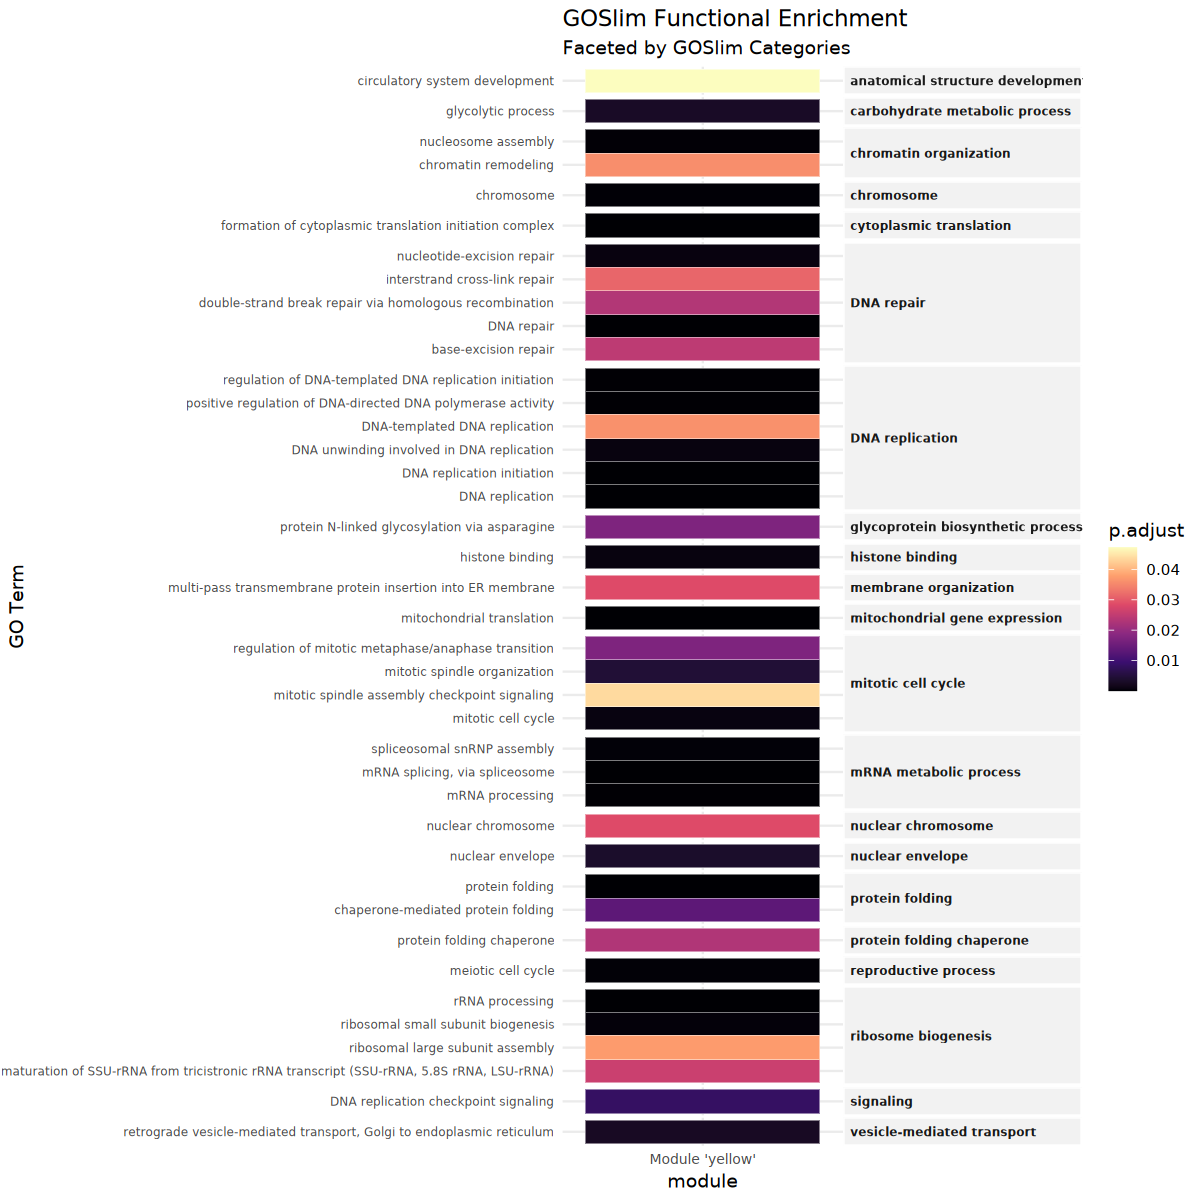

In [69]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(yellow_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

looks like a lot of DNA repair and replication - lot of epigenetic processes like chromatin organization and histone binding

### blue module
significantly correlated with phase 2 treatments control (neg.) hypoxic and warm (post.)

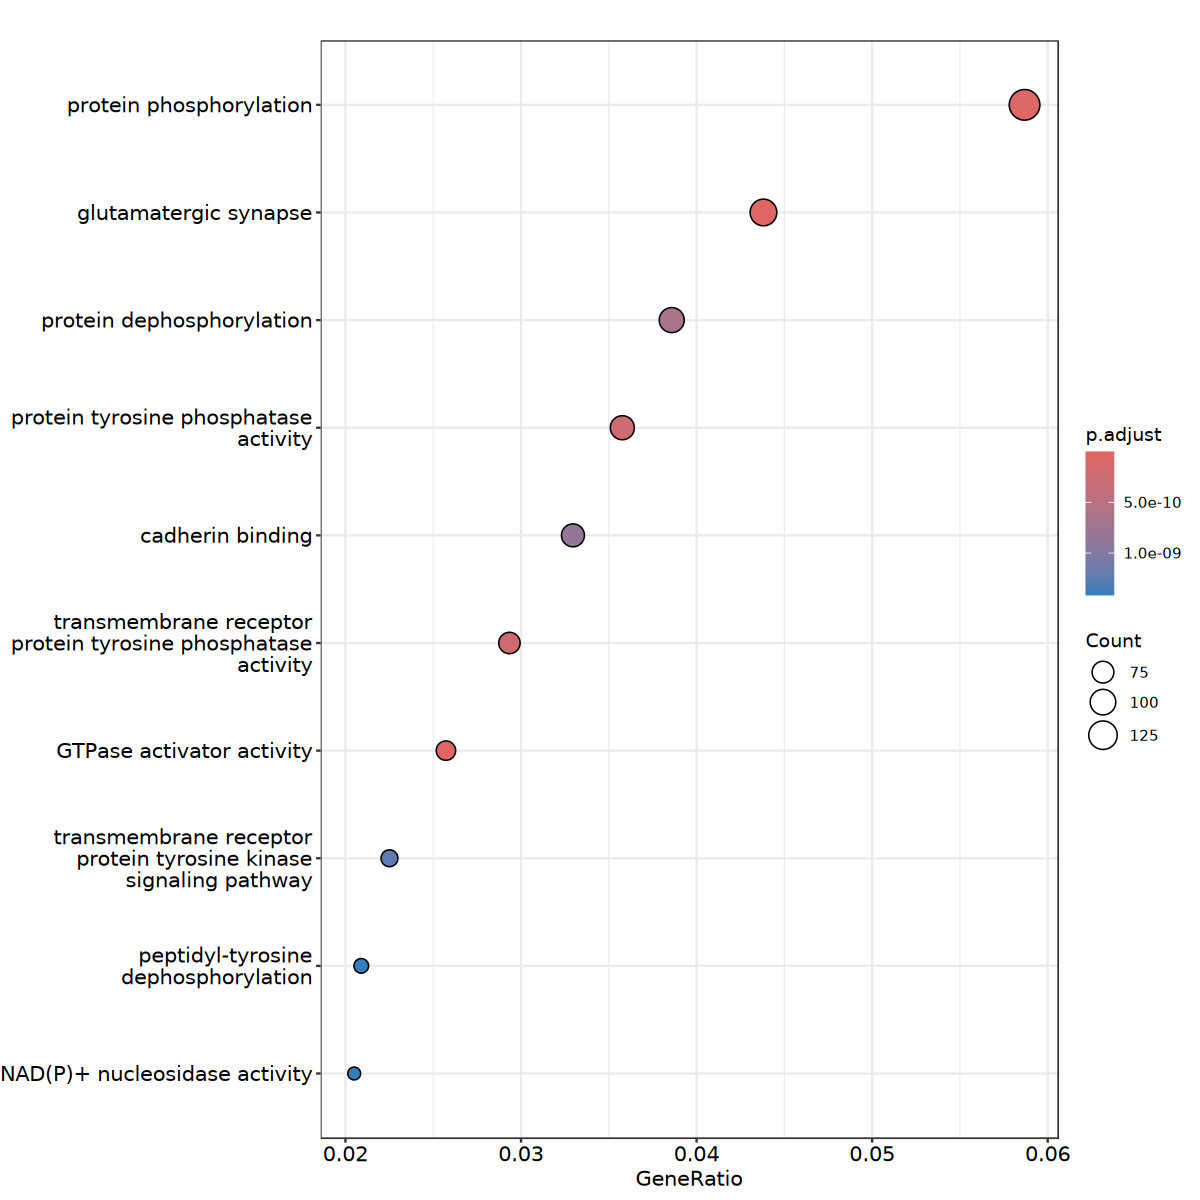

In [70]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "blue") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
blue_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [106]:
blue_mapped <- blue_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
blue_final <- blue_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'blue'")

head(blue_final)

ID         Description                                                     
1 GO:0007169 transmembrane receptor protein tyrosine kinase signaling pathway
2 GO:0035556 intracellular signal transduction                               
3 GO:0030336 negative regulation of cell migration                           
4 GO:1904893 negative regulation of receptor signaling pathway via STAT      
5 GO:0002224 toll-like receptor signaling pathway                            
6 GO:0045087 innate immune response                                          
  GeneRatio BgRatio   pvalue       p.adjust     qvalue      
1 56/2488   122/13421 3.576002e-12 1.243555e-09 1.042687e-09
2 66/2488   161/13421 2.450948e-11 5.682114e-09 4.764299e-09
3 60/2488   148/13421 3.335892e-10 4.218387e-08 3.537003e-08
4 40/2488   82/13421  4.455056e-10 5.164153e-08 4.330002e-08
5 47/2488   105/13421 5.511884e-10 6.133624e-08 5.142878e-08
6 110/2488  353/13421 4.934957e-09 4.037956e-07 3.385717e-07
  geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1 LOC111103722/LOC111106539/LOC111107445/LOC111107549/LOC111107550/LOC111109191/LOC111109831/LOC111110330/LOC111110390/LOC111111946/LOC111111948/LOC111112366/LOC111112739/LOC111113138/LOC111113167/LOC111113168/LOC111113170/LOC111113179/LOC111113207/LOC111113430/LOC111113685/LOC111114475/LOC111114500/LOC111114502/LOC111114722/LOC111114723/LOC111115259/LOC111115262/LOC111115264/LOC111116053/LOC111116632/LOC111117321/LOC111117327/LOC111117345/LOC111117469/LOC111117666/LOC111118172/LOC111118720/LOC111119050/LOC111119192/LOC111119718/LOC111119719/LOC111119769/LOC111119805/LOC111120008/LOC111120801/LOC111121258/LOC111123772/LOC111124011/LOC111125677/LOC111129309/LOC111129741/LOC111130114/LOC111134024/LOC111134499/LOC111134583                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2 LOC111100277/LOC111100477/LOC111104269/LOC111104302/LOC111104335/LOC111105688/LOC111106022/LOC111107301/LOC111107545/LOC111107852/LOC111108129/LOC111108201/LOC1111

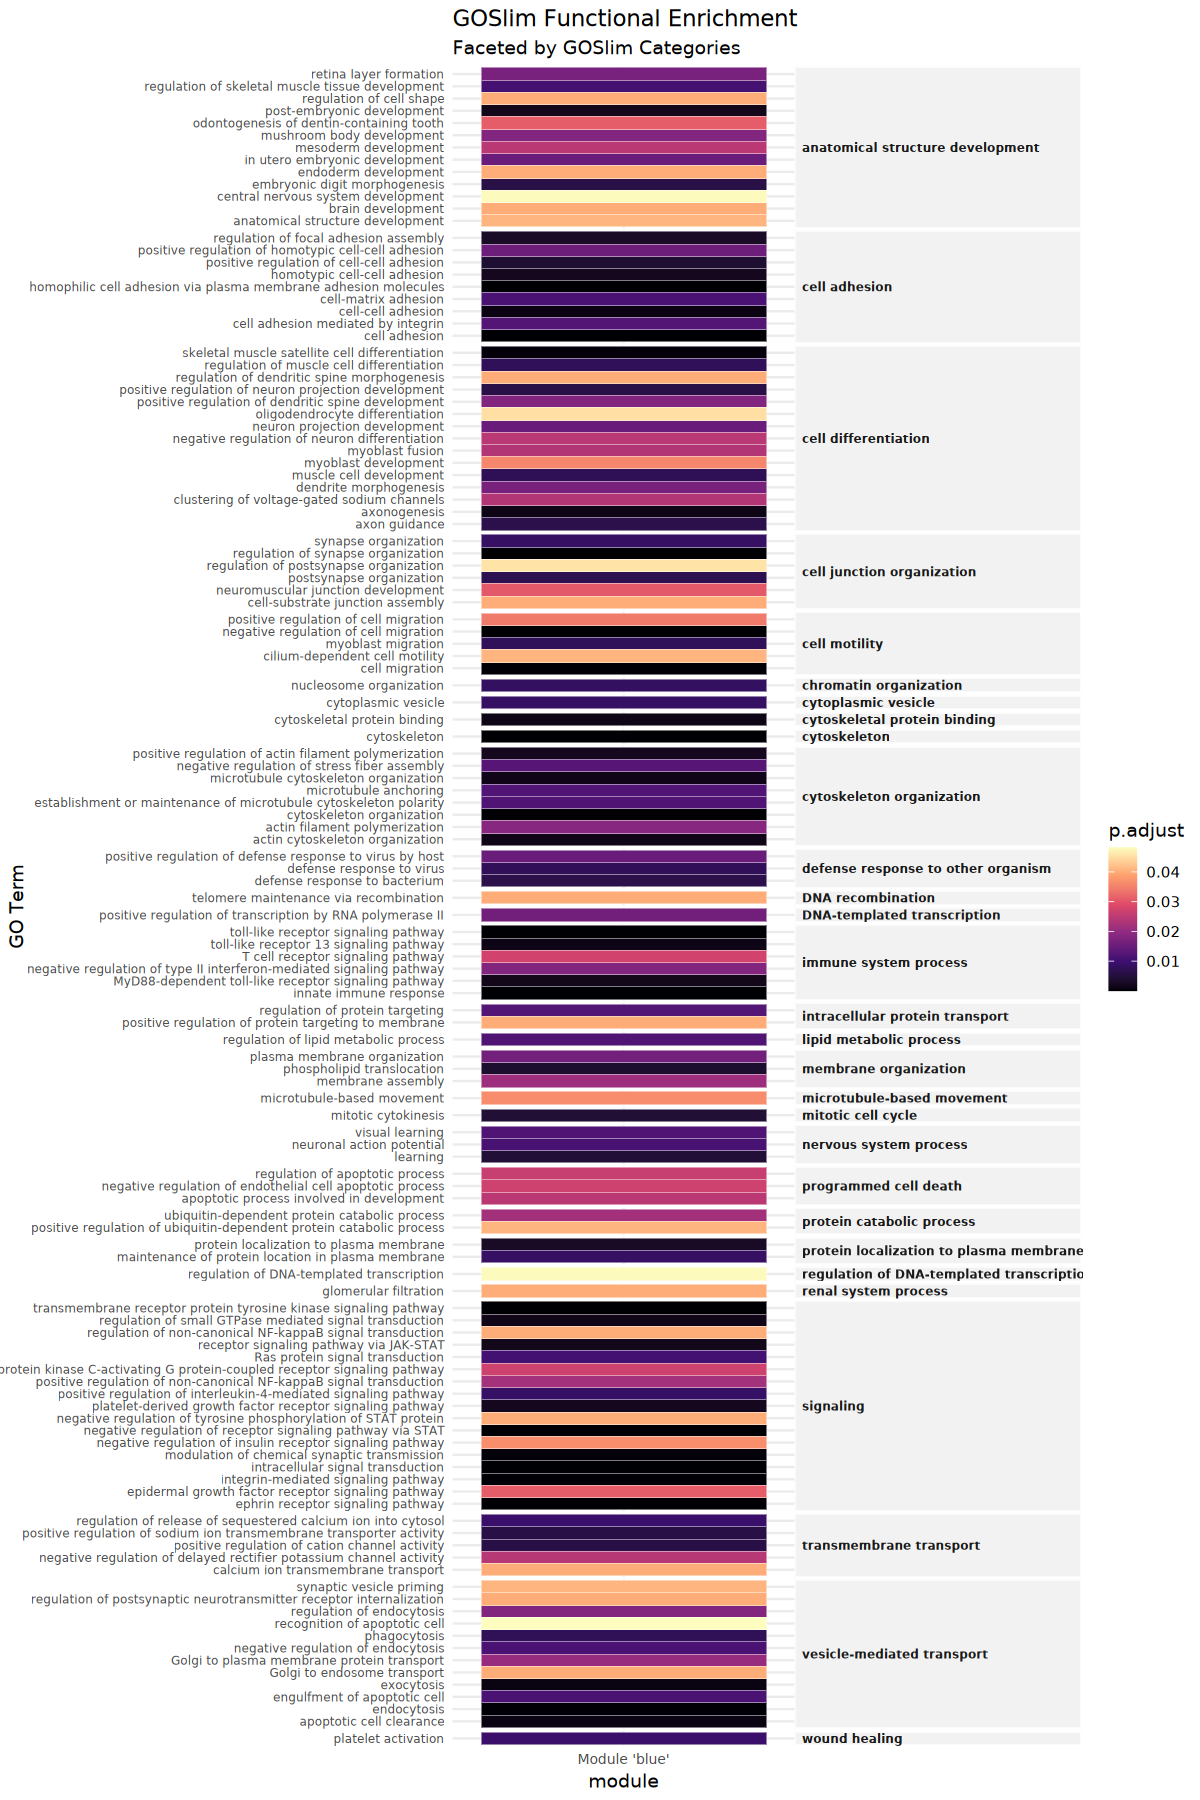

In [76]:
options(repr.plot.width = 10, repr.plot.height = 15)

ggplot(blue_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

more structural development - cell differentation, adhesion, development - lots of signaling and transport

wound healing and programmed cell death is interesting too - these genes tend to have higher expression in treatments warm and hypoxic (single stressors) and lower in control conditions

### salmon module
significantly correlated with phase 2 treatments control (neg.) and both (pos.), phase 2 DO (neg. for normoxic), and phase 2 temp (neg. for ambient)

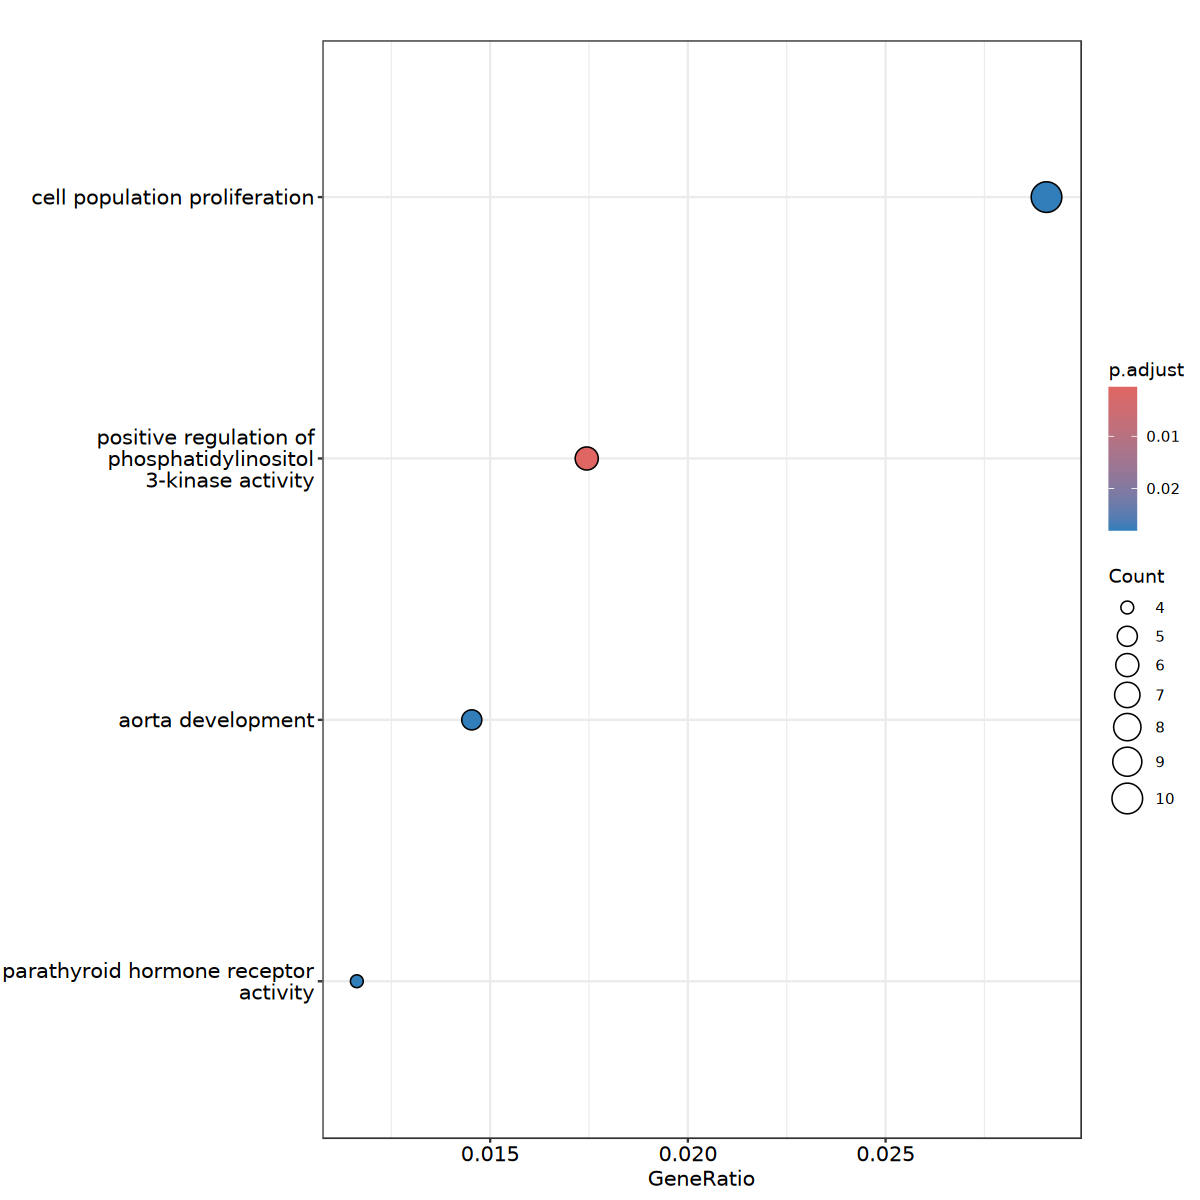

In [73]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "salmon") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
salmon_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [105]:
salmon_mapped <- salmon_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
salmon_final <- salmon_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'salmon'")

head(salmon_final)

ID         Description                                                  
1 GO:0043552 positive regulation of phosphatidylinositol 3-kinase activity
2 GO:0035904 aorta development                                            
  GeneRatio BgRatio  pvalue       p.adjust     qvalue     
1 6/344     13/13421 4.002321e-07 0.0005463168 0.000506399
2 5/344     17/13421 5.158176e-05 0.0280553444 0.026005417
  geneID                                                                       
1 LOC111103567/LOC111117013/LOC111127933/LOC111132433/LOC111135071/LOC111135079
2 LOC111100798/LOC111118003/LOC111120703/LOC111125814/LOC111127147             
  Count SlimID     GOSlim_Bin                       module  
1 6     GO:0006629 lipid metabolic process          'salmon'
2 5     GO:0048856 anatomical structure development 'salmon'

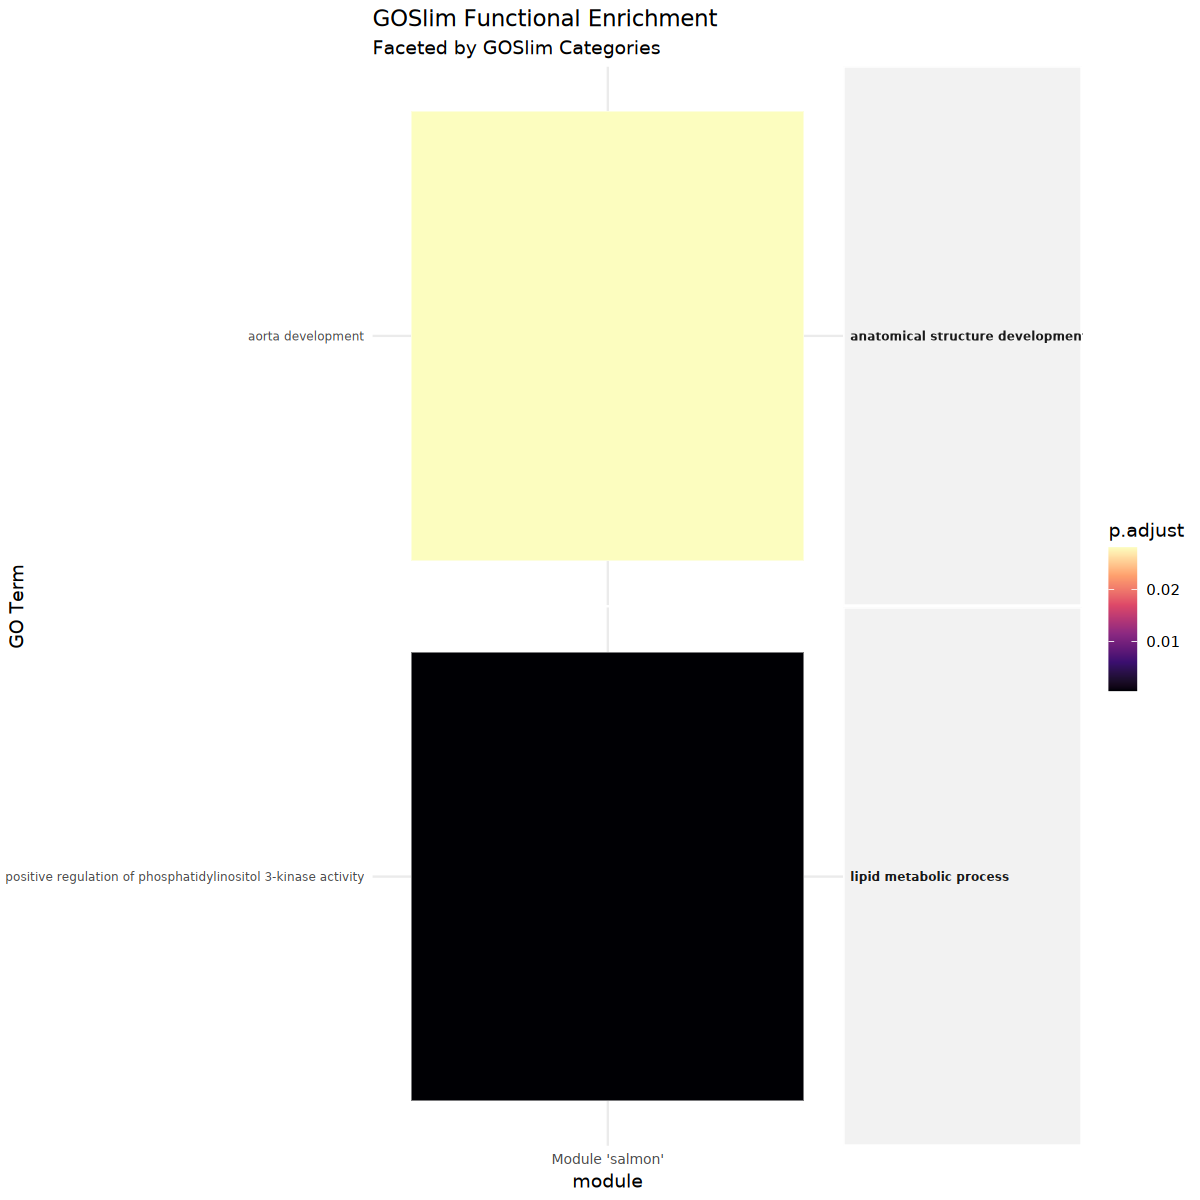

In [75]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(salmon_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

interesting - this module is significantly correlated with a lot of traits/treatments, but is 'concentrated' in terms of what those genes are involved in - only two GO terms, which match to two broader parent terms - anatomical structure development and lipid metabolic process

anatomic structure development has come up in almost every module, but (maybe obviously?) different associated terms - here we see aorta development, which is related to the heart

### magenta module
significantly correlated with phase 2 treatments control (neg.) and both (pos.), phase 2 DO (neg. for normoxic), and phase 2 temp (neg. for ambient) - has similar patterns with the salmon module 

In [94]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "magenta") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
magenta_res <- as.data.frame(ego_custom)
head(magenta_res)

ID Description GeneRatio BgRatio pvalue p.adjust qvalue geneID Count

no GO terms! which is really surprising - I wonder how many genes are in this module?

In [92]:
sort(table(geneInfo$ModuleColor), decreasing = TRUE)


        blue       yellow    turquoise        brown          red        green 
        2778         2292         2272         1702         1142          824 
       black      magenta         pink  greenyellow       salmon         cyan 
         768          663          624          482          360          249 
         tan midnightblue 
         207          165 

663 genes in magenta ... ? so that's really surprising that there's no GO terms that show up for magenta...

### turquoise module
significantly correlated with phase 2 temp (neg. for ambient) and phase 2 treatment hypoxic (neg.)

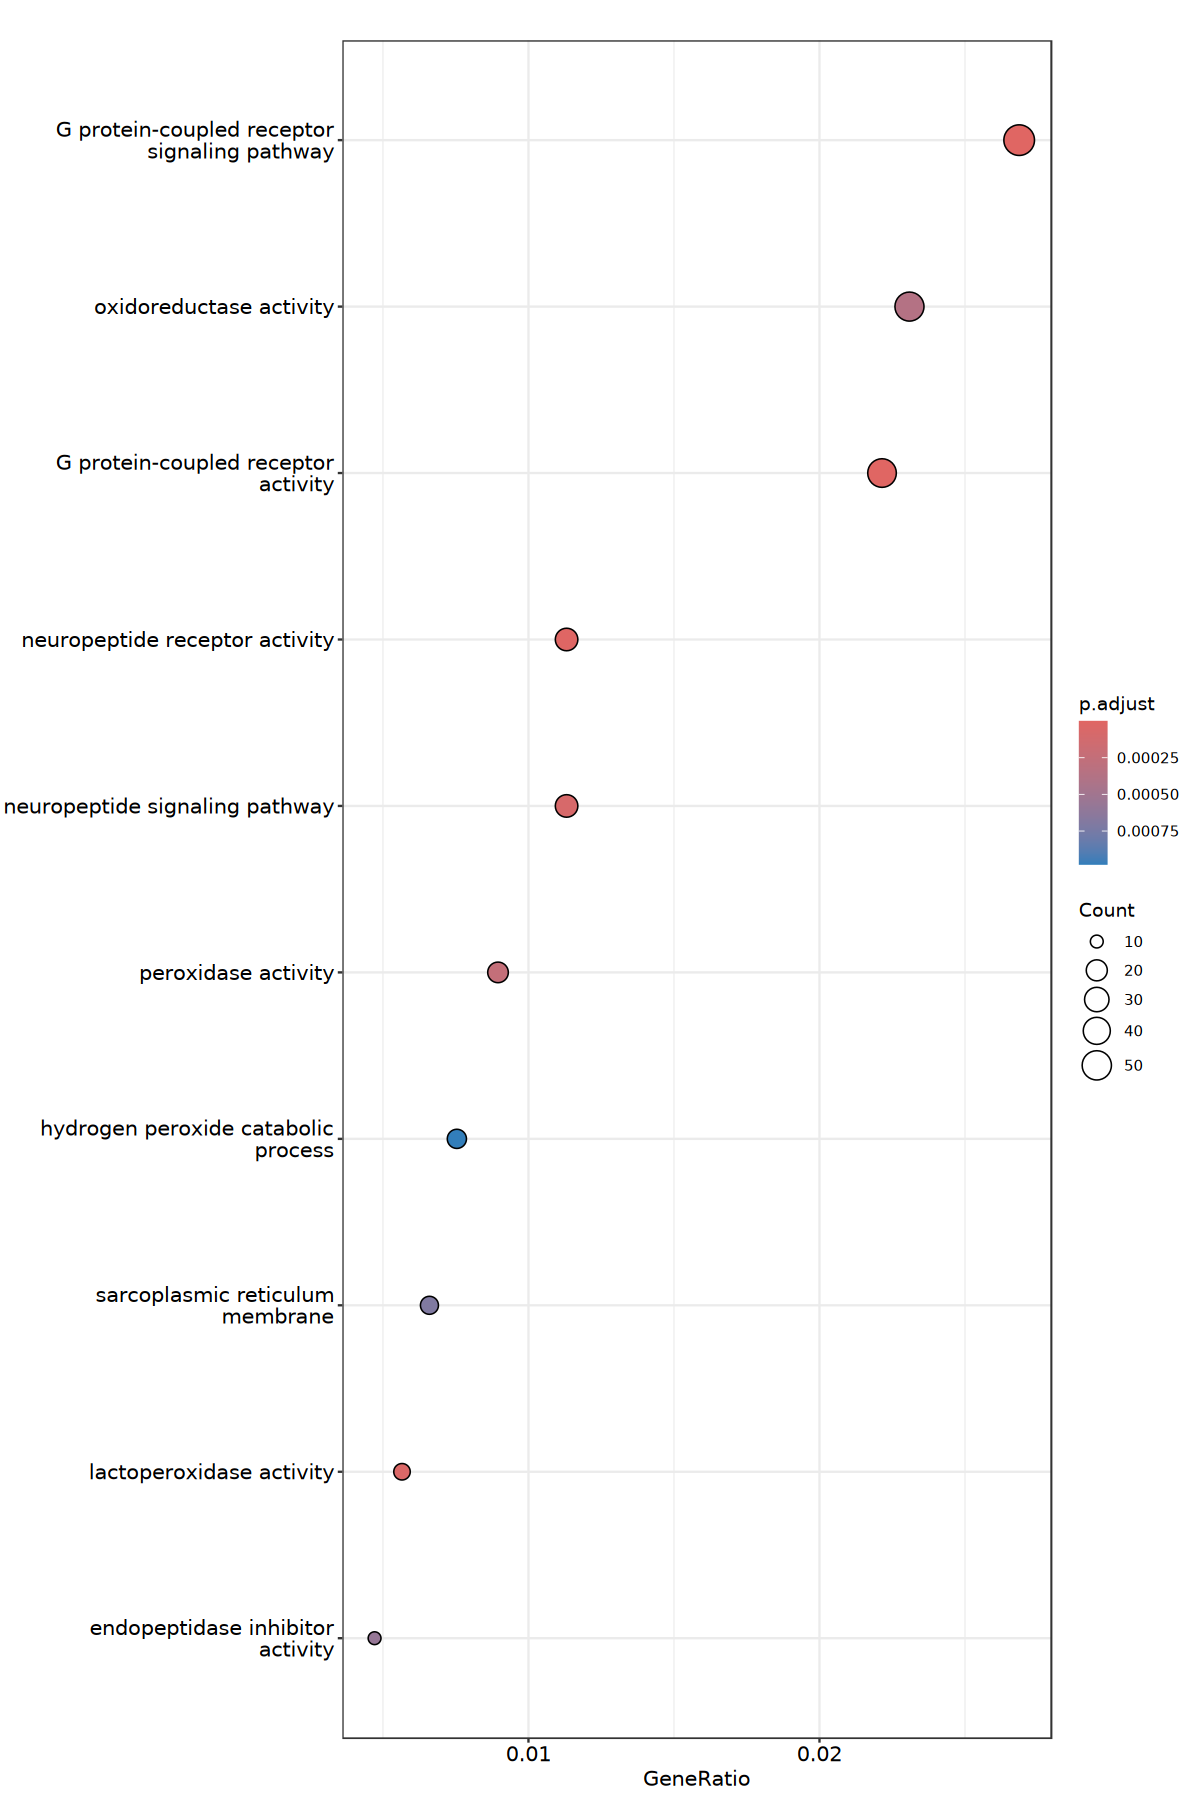

In [97]:
target_genes <- geneInfo %>%
  filter(ModuleColor == "turquoise") %>%
  pull(Gene)

# Run the custom enrichment
ego_custom <- enricher(gene = target_genes,
                       universe = universal_genes$gene,
                       TERM2NAME = term2name,
                       TERM2GENE = term2gene,
                       pvalueCutoff = 0.05)

# make df
turquoise_res <- as.data.frame(ego_custom)

# View results
dotplot(ego_custom)

look for parent terms/bin GO terms to broader categories

In [104]:
turquoise_mapped <- turquoise_res %>%
  # Process each row's ID individually
  rowwise() %>%
  # use function from earlier to map parent term to GO ID
  mutate(SlimID = find_slim_parent(ID, target_slim_ids)) %>% 
  ungroup() %>%
  # Join with lookup table to get 'GOSlim_Bin'
  left_join(slim_lookup, by = "SlimID")

# Remove terms that didn't map to a slim category if desired
turquoise_final <- turquoise_mapped %>%
  filter(!is.na(GOSlim_Bin)) %>%
mutate(module = "'turquoise'")

head(turquoise_final)

ID        
1 GO:0007186
2 GO:0007218
3 GO:0016491
4 GO:0045214
5 GO:0042730
6 GO:0007189
  Description                                                              
1 G protein-coupled receptor signaling pathway                             
2 neuropeptide signaling pathway                                           
3 oxidoreductase activity                                                  
4 sarcomere organization                                                   
5 fibrinolysis                                                             
6 adenylate cyclase-activating G protein-coupled receptor signaling pathway
  GeneRatio BgRatio   pvalue       p.adjust     qvalue      
1 57/2122   155/13421 1.407838e-10 1.876648e-07 1.778321e-07
2 24/2122   51/13421  1.529442e-07 8.154984e-05 7.727706e-05
3 49/2122   157/13421 9.747936e-07 3.712571e-04 3.518052e-04
4 15/2122   29/13421  7.784522e-06 1.596426e-03 1.512782e-03
5 10/2122   15/13421  1.333096e-05 2.538596e-03 2.405587e-03
6 27/2122   78/13421  3.442494e-05 5.098716e-03 4.831570e-03
  geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1 LOC111100098/LOC111100808/LOC111101050/LOC111101103/LOC111101865/LOC111102619/LOC111102697/LOC111102827/LOC111102829/LOC111102950/LOC111103785/LOC111103786/LOC111104770/LOC111104793/LOC111105330/LOC111105569/LOC111108126/LOC111109931/LOC111110890/LOC111110917/LOC111111182/LOC111111622/LOC111112625/LOC111112679/LOC111112680/LOC111114749/LOC111115391/LOC111118486/LOC111118494/LOC111118562/LOC111118671/LOC111119111/LOC111120562/LOC111121181/LOC111121244/LOC111121449/LOC111121622/LOC111121917/LOC111121937/LOC111121977/LOC111122002/LOC111122039/LOC111123376/LOC111123870/LOC111124959/LOC111125706/LOC111126548/LOC111126782/LOC111127078/LOC111130789/LOC111130833/LOC111131046/LOC111132623/LOC111133698/LOC111134195/LOC111136984/LOC111137071
2 LOC111100098/LOC111101865/LOC111102619/LOC111102697/LOC111103786/LOC111110267/LOC111118133/LOC111118311/LOC111119111/LOC111121917/LOC111121977/LOC111122281/LOC111123376/LOC111123723/LOC111123870/LOC111124959/LOC111125046/LOC111126221/LOC111130401/LOC111131046/LOC111132102/LOC111133698/LOC111133878/LOC111135239                                                                                                                                                                                                                                                                                                                                                                                                                                             
3 LOC111100706/LOC111104261/LOC111104581/LOC111106942/LOC111108980/LOC111110105/LOC111110523/LOC111110785/LOC111110787/LOC111111108/LOC111111712/LOC111111879/LOC111111880/LOC111111884/LOC111113864/LOC111113890/LOC111114621/LOC111115434/LOC111115523/LOC111115724/LOC111118881/LOC111119819/LOC111120112/LOC111120485/LOC111122283/LOC111122794/LOC111123608/LOC111124483/LOC111128355/LOC111128455/LOC111131635/LOC111131741/LOC111131772/LOC111131774/LOC111133197/LOC111133732/LOC111133776/LOC111133989/LOC111134409/LOC111135001/LOC111135946/LOC111136100/LOC111136225/LOC111136226/LOC111136540/LOC111136737/LOC111137600/LOC111137992/LOC111138284                                                                                     

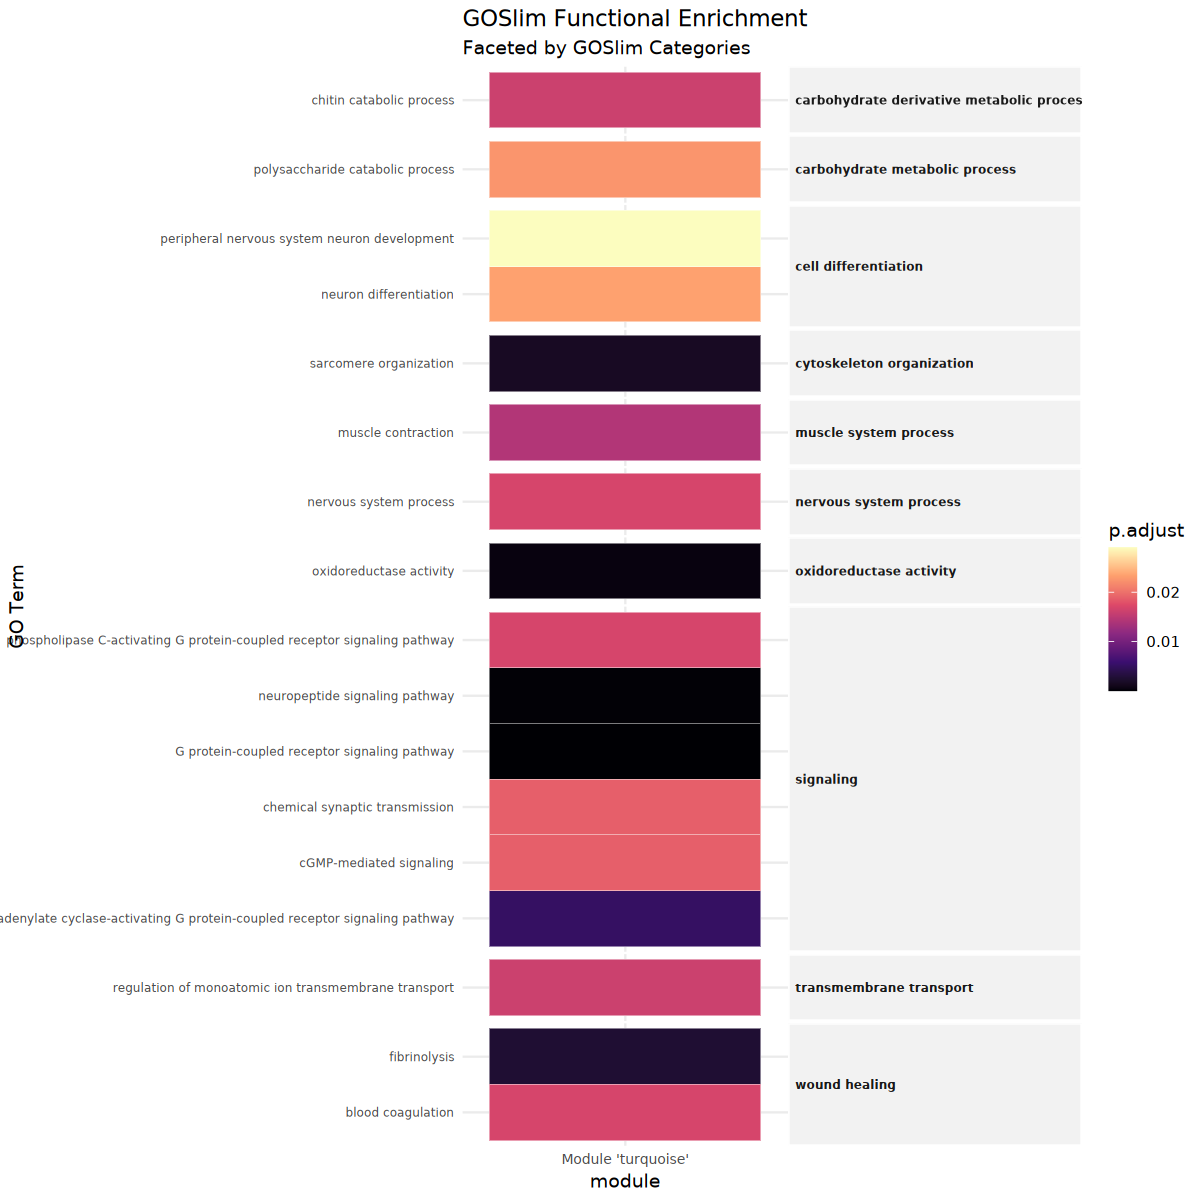

In [99]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(turquoise_final, aes(x = module, y = Description, fill = p.adjust)) +
  geom_tile(color = "white", size = 0.1) +
  # Grouping by GOSlim Category on the right side
  facet_grid(GOSlim_Bin ~ ., scales = "free_y", space = "free_y") +
  # Use a color scale that makes significant results "pop"
  scale_fill_viridis_c(option = "magma") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(size = 8),
    panel.spacing = unit(0.1, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by GOSlim Categories",
    y = "GO Term"
  )

structural development, wound healing, signaling (communication), little bit of carb metabolism (**chitin**!!)

as a reminder, this module was significantly negatively correlated with ambient temps and hypoxic treatment in phase 2 (meaning, phase 2 warming had higher expression of this module compared to ambient and regardless of phase 1 treatment; phase 2 hypoxic treatment (ambient temp, hypoxic DO) has lower expression of this module compared to other treatments (control, warm, both) and regardless of phase 1 treatment)

## combining these:

In [113]:
# combine all sig. modules GO results
module.GO <- rbind(midnightblue_final, green_final, cyan_final, yellow_final, blue_final, salmon_final, turquoise_final)

In [129]:
# add whether the module was sig. correlated with phase 1 or phase 2 treatments/traits
module.GO <- module.GO %>%
mutate(sigCor_phase = case_when(
    module %in% c("'midnightblue'", "'green'") ~ "phase1", 
    # Everything else gets 'phase2'
    TRUE ~ "phase2"
  ))

# check it worked
head(module.GO)
tail(module.GO)

ID         Description                                         GeneRatio
1 GO:0035262 gonad morphogenesis                                 4/148    
2 GO:1903354 regulation of distal tip cell migration             4/148    
3 GO:0030334 regulation of cell migration                        7/148    
4 GO:0007026 negative regulation of microtubule depolymerization 4/148    
5 GO:0000398 mRNA splicing, via spliceosome                      8/148    
6 GO:0007004 telomere maintenance via telomerase                 3/148    
  BgRatio   pvalue       p.adjust     qvalue      
1 10/13421  2.832179e-06 0.0005558152 0.0004583659
2 10/13421  2.832179e-06 0.0005558152 0.0004583659
3 65/13421  7.015019e-06 0.0011013579 0.0009082603
4 20/13421  5.996044e-05 0.0047068943 0.0038816494
5 134/13421 1.168935e-04 0.0083419433 0.0068793766
6 13/13421  3.465583e-04 0.0170030174 0.0140219319
  geneID                                                                                                 
1 LOC111123643/LOC111124270/LOC111125152/LOC111125159                                                    
2 LOC111123643/LOC111124270/LOC111125152/LOC111125159                                                    
3 LOC111111223/LOC111115638/LOC111123643/LOC111124270/LOC111125152/LOC111125159/LOC111132609             
4 LOC111111223/LOC111112299/LOC111115638/LOC111135618                                                    
5 LOC111102673/LOC111123630/LOC111124615/LOC111125036/LOC111127735/LOC111132362/LOC111134422/LOC111138362
6 LOC111108767/LOC111127260/LOC111127309                                                                 
  Count SlimID     GOSlim_Bin                module         sigCor_phase
1 4     GO:0022414 reproductive process      'midnightblue' phase1      
2 4     GO:0048870 cell motility             'midnightblue' phase1      
3 7     GO:0048870 cell motility             'midnightblue' phase1      
4 4     GO:0007010 cytoskeleton organization 'midnightblue' phase1      
5 8     GO:0016071 mRNA metabolic process    'midnightblue' phase1      
6 3     GO:0032200 telomere organization     'midnightblue' phase1

ID         Description                                  GeneRatio BgRatio  
1 GO:0050877 nervous system process                       33/2122   112/13421
2 GO:0019934 cGMP-mediated signaling                      14/2122   33/13421 
3 GO:0007268 chemical synaptic transmission               47/2122   180/13421
4 GO:0000272 polysaccharide catabolic process             13/2122   30/13421 
5 GO:0030182 neuron differentiation                       25/2122   79/13421 
6 GO:0048935 peripheral nervous system neuron development 7/2122    11/13421 
  pvalue       p.adjust   qvalue    
1 0.0001893902 0.01683048 0.01594865
2 0.0002417939 0.01879503 0.01781027
3 0.0002467464 0.01879503 0.01781027
4 0.0003124077 0.02251024 0.02133082
5 0.0003334407 0.02339350 0.02216780
6 0.0004474774 0.02909695 0.02757242
  geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1 LOC111101827/LOC111102531/LOC111103449/LOC111108340/LOC111108705/LOC111109243/LOC111110353/LOC111115939/LOC111117968/LOC111118326/LOC111118405/LOC111118424/LOC111119694/LOC111122060/LOC111122321/LOC111122567/LOC111122706/LOC111123723/LOC111125046/LOC111126221/LOC111126388/LOC111126783/LOC111130256/LOC111130390/LOC111130744/LOC111130866/LOC111131084/LOC111131087/LOC111131182/LOC111131854/LOC111134074/LOC111134787/LOC111138356                                                                                                                                                                                      
2 LOC111108278/LOC111110860/LOC111114546/LOC111118725/LOC111120351/LOC111124375/LOC111126760/LOC111126805/LOC111127151/LOC111128074/LOC111132202/LOC111133925/LOC111134052/LOC111136262                                                                                                                                                                                                                                                                                                                                                                                                                                             
3 LOC111101233/LOC111101827/LOC111102304/LOC111102531/LOC111103069/LOC111103449/LOC111104676/LOC111104802/LOC111109243/LOC111109931/LOC111110353/LOC111115391/LOC111115939/LOC111118326/LOC111118405/LOC111118424/LOC111122321/LOC111122567/LOC111122706/LOC111122736/LOC111122956/LOC111122967/LOC111123723/LOC111124426/LOC111124927/LOC111124989/LOC111125046/LOC111125072/LOC111125581/LOC111126221/LOC111126257/LOC111126388/LOC111126424/LOC111126516/LOC111126783/LOC111127322/LOC111130256/LOC111130390/LOC111130744/LOC111131084/LOC111131182/LOC111131854/LOC111132102/LOC111134052/LOC111136699/LOC111136947/LOC111138356
4 LOC111111335/LOC111111428/LOC111117031/LOC111117611/LOC111119602/LOC111119838/LOC111120789/LOC111122234/LOC111122235/LOC111128984/LOC111130320/LOC111130595/LOC111130788                                                                                                                                                                                                                                                                                                                                                                                                                                                          
5 LOC111099186/LOC111099909/LOC111100180/LOC111104277/LOC111105509/LOC111106587/LOC111109706/LOC111115094/LOC111118906/LOC111119233/

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warnin

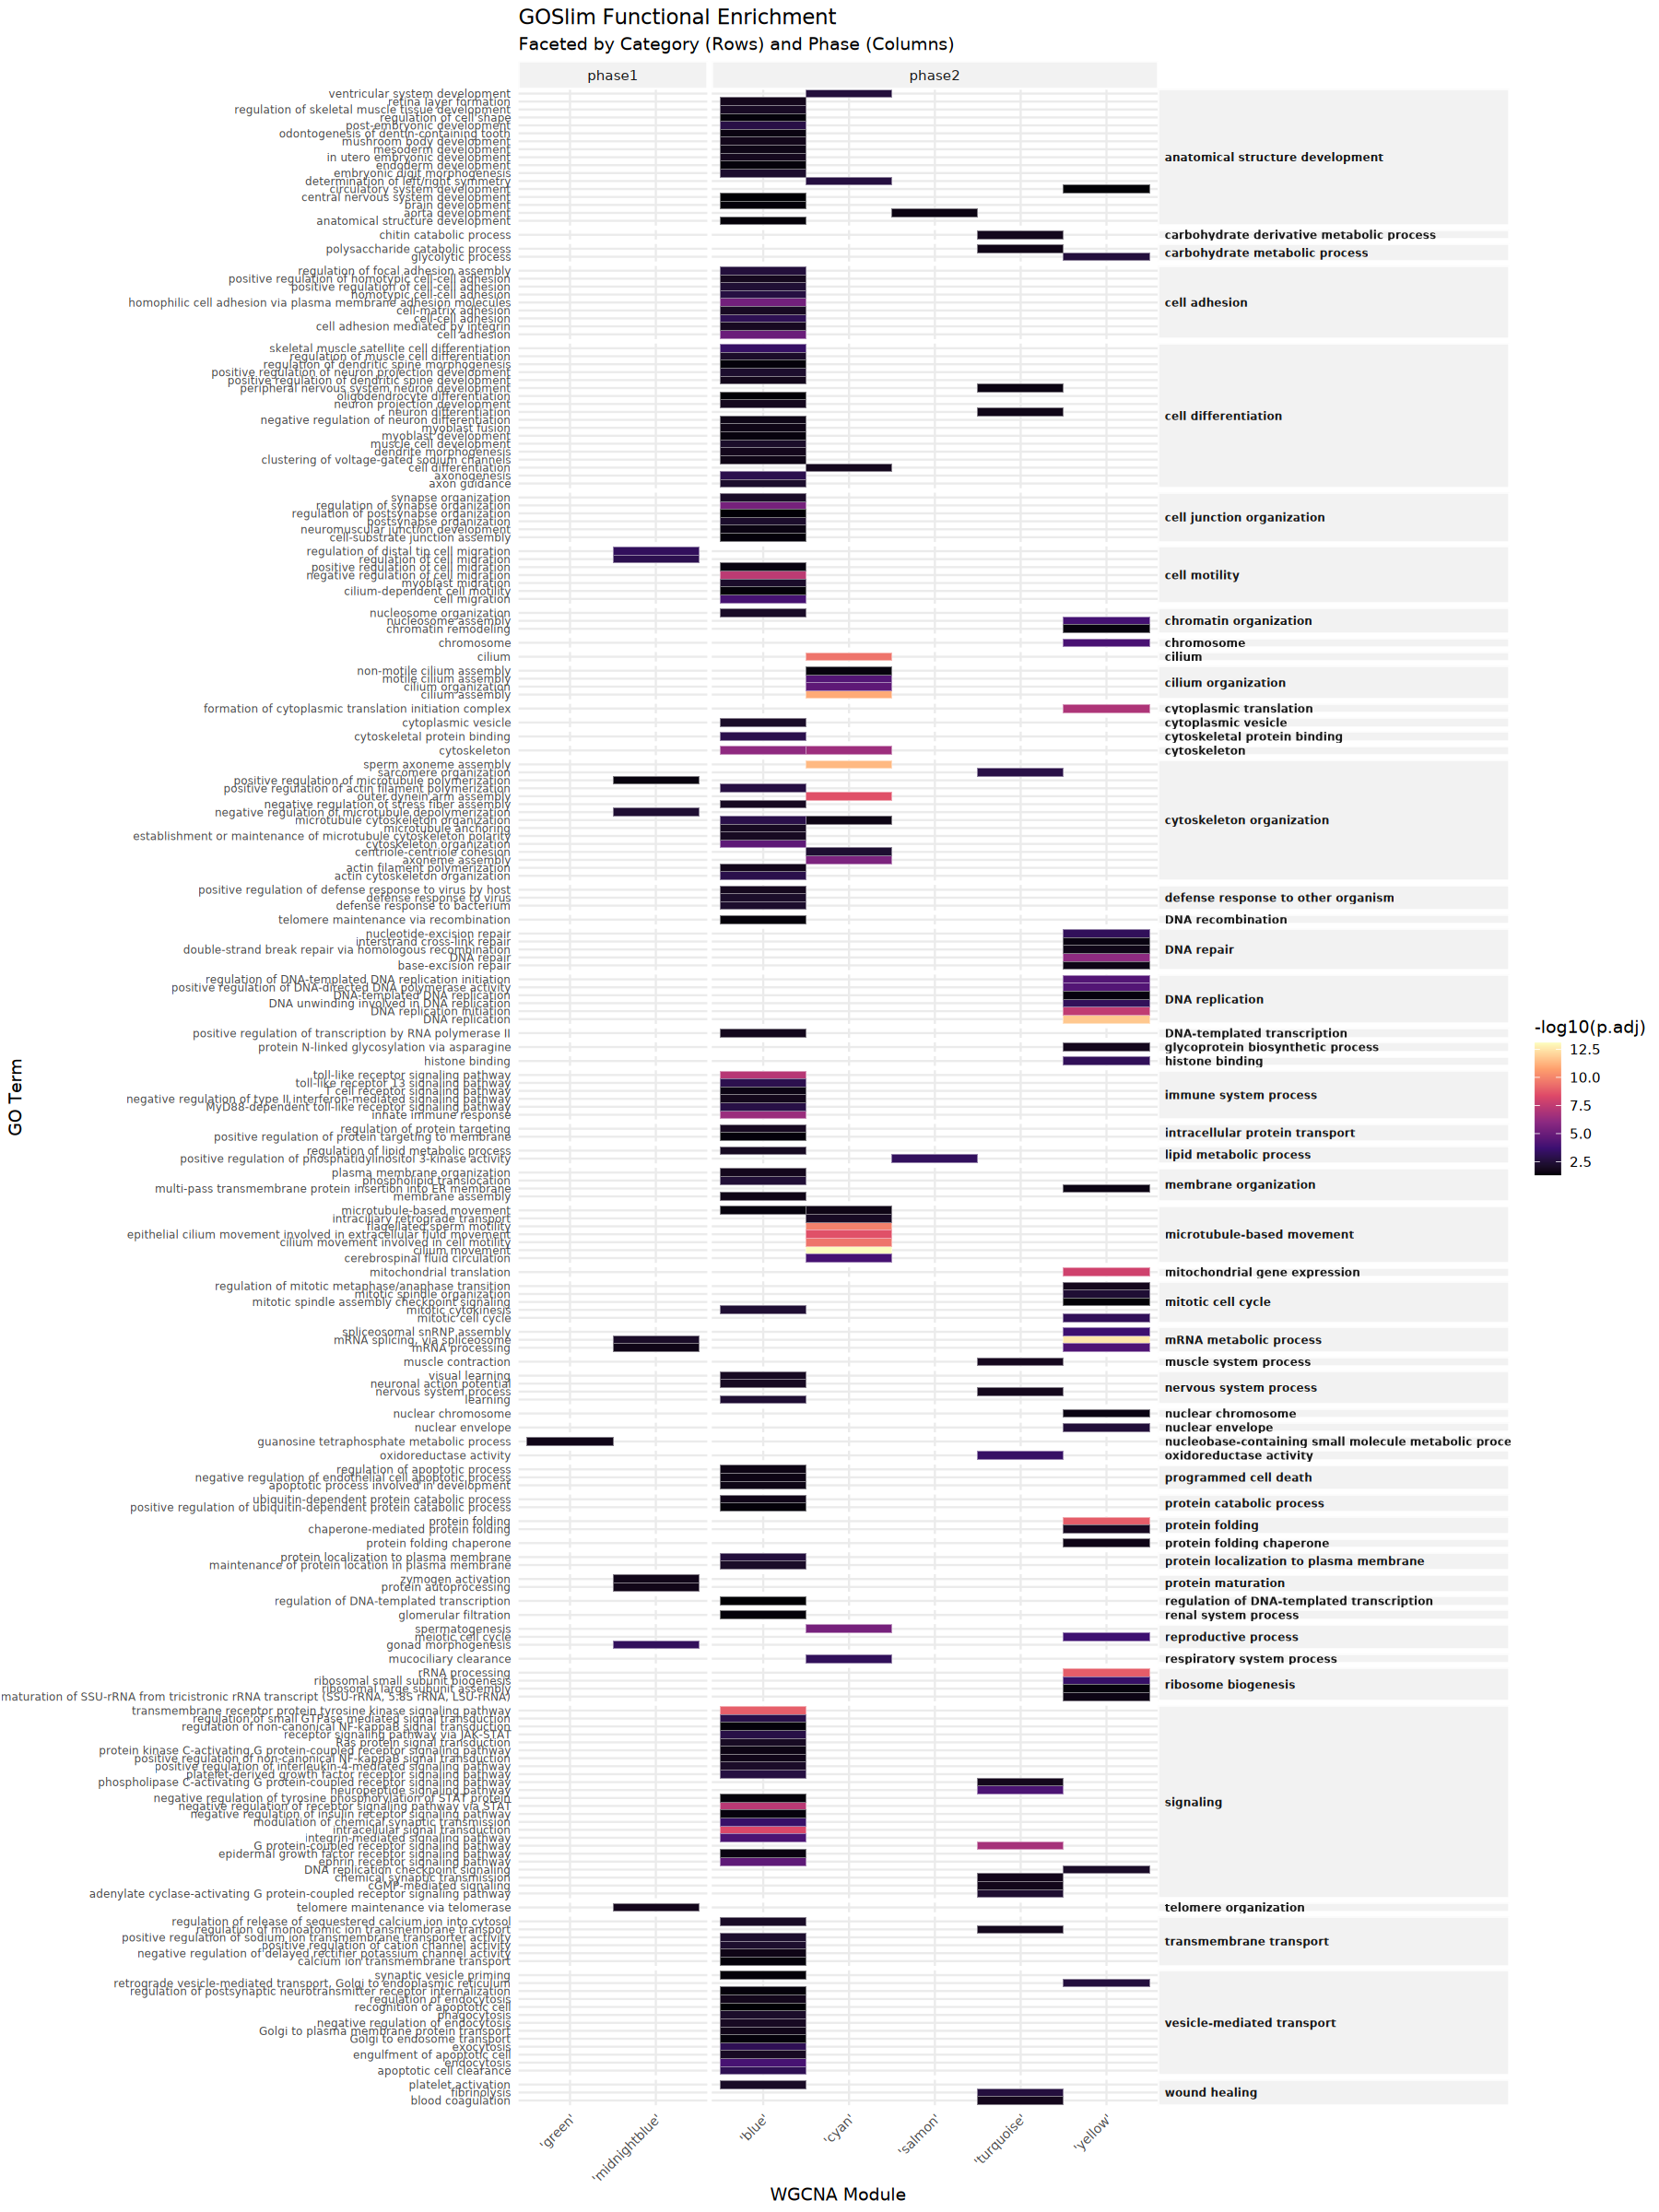

In [140]:
options(repr.plot.width = 15, repr.plot.height = 20)

ggplot(module.GO, aes(x = module, y = Description, fill = -log10(p.adjust))) +
  geom_tile(color = "white", linewidth = 0.1) + 
  # Rows = GOSlim_Bin, Columns = sigCor_phase
facet_grid(GOSlim_Bin ~ sigCor_phase, scales = "free", space = "free") +
scale_fill_viridis_c(option = "magma", name = "-log10(p.adj)") +
  theme_minimal() +
  theme(
    strip.text.y = element_text(angle = 0, size = 7, face = "bold", hjust = 0),
    strip.background = element_rect(fill = "gray95", color = "white"),
    axis.text.y = element_text(size = 7),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    panel.spacing = unit(0.2, "lines"),
    legend.position = "right"
  ) +
  labs(
    title = "GOSlim Functional Enrichment",
    subtitle = "Faceted by Category (Rows) and Phase (Columns)",
    y = "GO Term",
    x = "WGCNA Module"
  )

what if we remove GO terms - look at just GOSlim categories

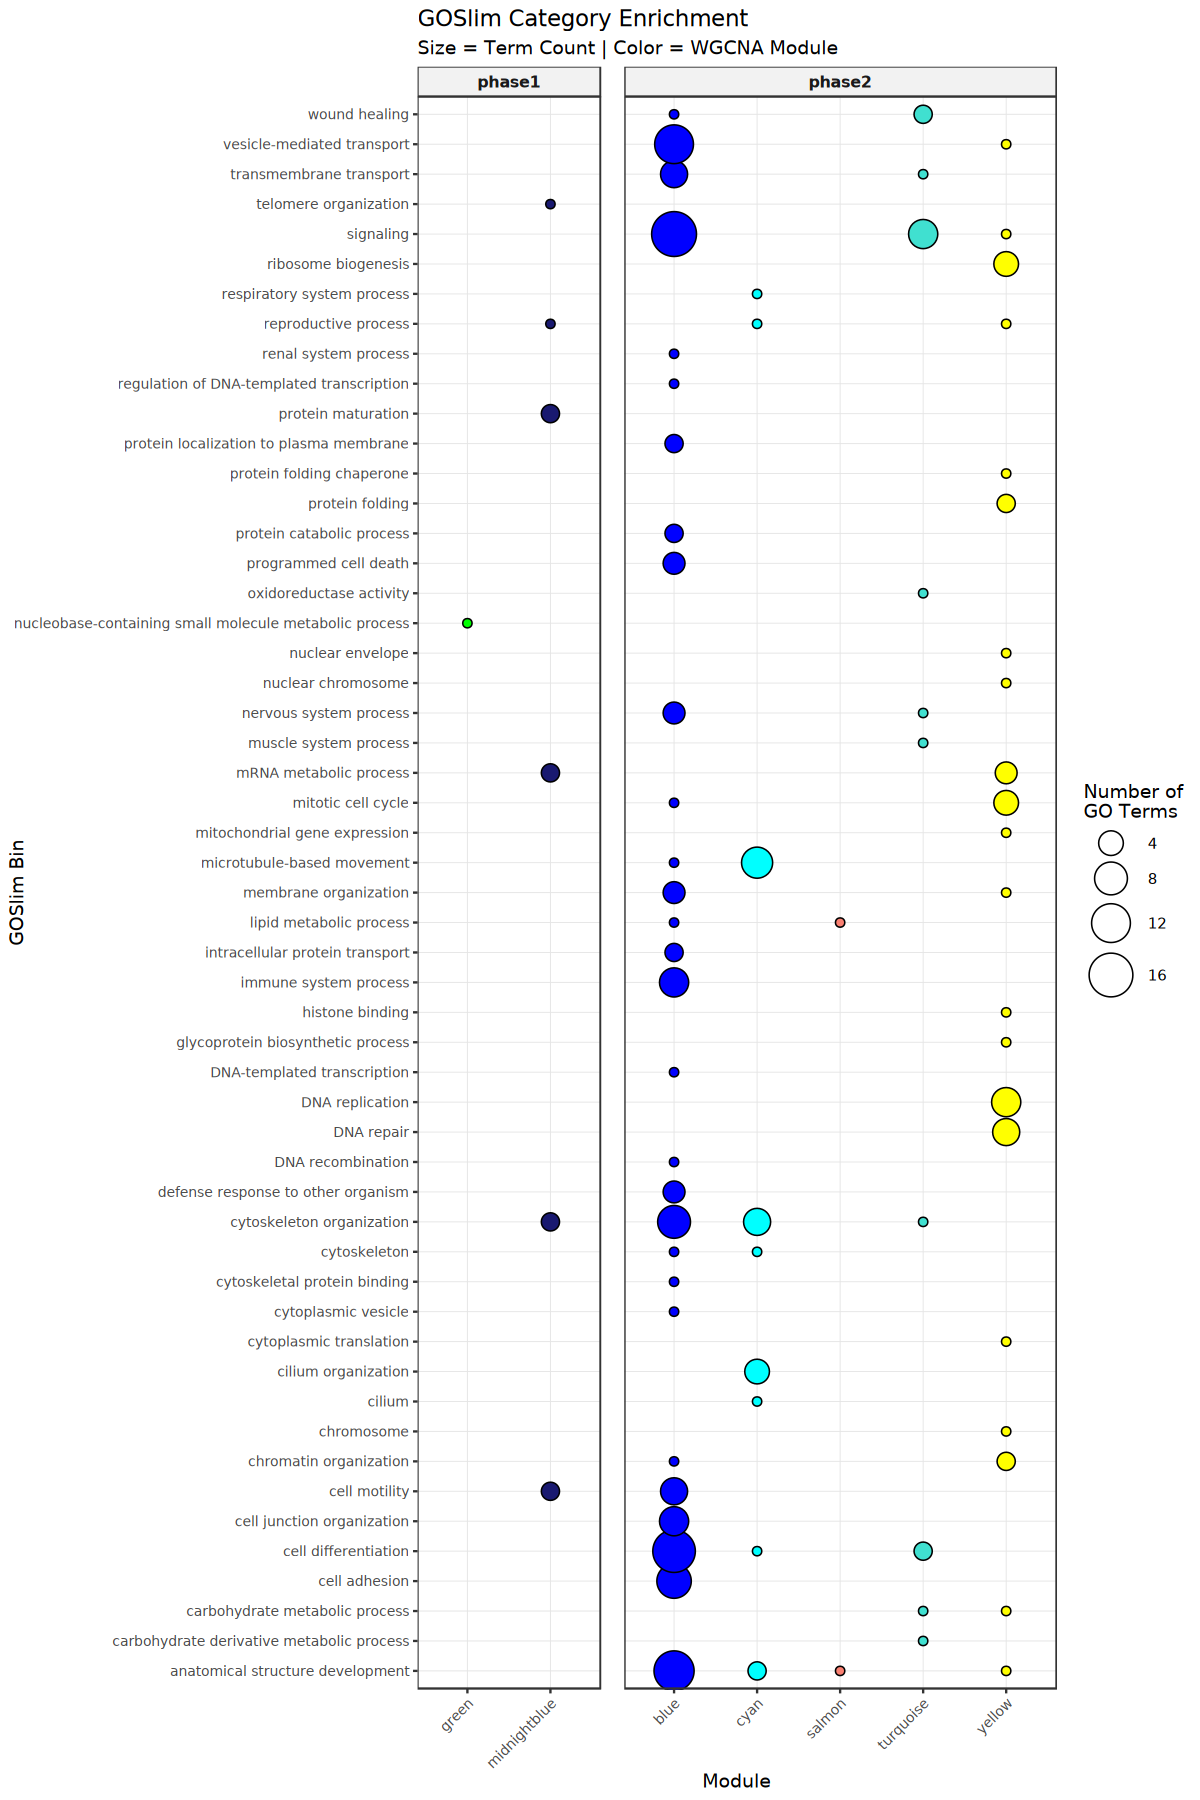

In [155]:
options(repr.plot.width = 10, repr.plot.height = 15)

# 1. Clean the strings and summarize
plot_summary <- module.GO %>%
  filter(!is.na(GOSlim_Bin), GOSlim_Bin != "", !is.na(sigCor_phase)) %>%
  # CLEANING STEP: Remove single quotes if they exist (e.g., 'green' -> green)
  mutate(module = str_replace_all(module, "'", "")) %>%
  group_by(module, GOSlim_Bin, sigCor_phase) %>%
  dplyr::summarize(GO_Count = n(), .groups = 'drop') %>% 
  mutate(across(where(is.character), as.factor))

plot_summary <- droplevels(plot_summary)

# 2. Plot with black outlines (shape 21)
ggplot(plot_summary, aes(x = module, y = GOSlim_Bin)) +
  # shape 21 uses 'fill' for the center and 'color' for the border
  geom_point(aes(size = GO_Count, fill = module), shape = 21, color = "black", stroke = 0.5) + 
  facet_grid(. ~ sigCor_phase, scales = "free_x", space = "free_x") +
  # Tell ggplot to use the literal module names for the fill
  scale_fill_identity() + 
  scale_size_continuous(range = c(2, 12), name = "Number of\nGO Terms") +
  theme_bw() +
  theme(
    strip.text.x = element_text(size = 9, face = "bold"),
    strip.background = element_rect(fill = "gray95"),
    axis.text.y = element_text(size = 8),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    panel.spacing = unit(1, "lines"),
    panel.grid.major = element_line(color = "gray90", size = 0.2)
  ) +
  labs(
    title = "GOSlim Category Enrichment",
    subtitle = "Size = Term Count | Color = WGCNA Module",
    y = "GOSlim Bin",
    x = "Module"
  )

here, the phase 1 column is for modules associated with phase 1 treatments (treatment as a whole or isolated temp/DO), and same for phase 2 - these results are from oysters that experienced both phase 1 *and* 2